# Outline

In this notebook my goal was to evaluate the features that were computed in the feature notebook. I wanted to see which features (if any) had predictive value intraday or within 1 day using the `spy` etf. 

The notebook is broken out into 3 sections:

1. In this section I used 3 ensemble models to try and predict the sign of the future return. This uses regular time bars and is predicting the binary class up or down.
2. In this section I use the framework outlined by De Prado. First we create Dollar Bars which are bars that are sampled after an equal number of dollar volume is traded. This is to ensure that equal amounts of information are contained within each bar. See these links for more information on these data structures [1](https://github.com/hudson-and-thames/research/blob/master/Advances%20in%20Financial%20Machine%20Learning/Financial%20Data%20Structures/Getting%20Started.ipynb), [2](https://mlfinlab.readthedocs.io/en/latest/implementations/data_structures.html), [3](https://github.com/hudson-and-thames/presentations/blob/master/Data%20Structures.pdf) In this section we also use the triple barrier labeling method which labels return which uses a profit target, stop loss and time horizon to label outcomes. We use three different ensemble models to make predictions. 
3. In this section we follow the same process as section 2 except I combine features computed using two different time frames to see if that improves the predictive accuracy of the models. 

In each section we run Shapley Feature selection. From the shap features we select those that exceed the mean value. I focus on using SHAP metrics because of its efficiency (speed wise) and its consistency as demonstrated in the following [paper](https://mlfinlab.slack.com/archives/CTQ7LHHDX/p1590588256166300?thread_ts=1590588256.166300) by Dr EP Chan and associates concerning feature selection consistency.

In each section I demonstrate the use of a tool called neptune to optimize the model parameters using the training set and validation set. Please sign up for [neptune.ai](https://neptune.ai/) and get a free api key. Please note the use of the hyperparameter optimization is demonstrated in separate python scripts. After that we run a final test on the hold out data or test set. This will give us insight into whether the feature sets have predictive power.

# Imports

In [1]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2

# import standard libs
import warnings
import os

warnings.filterwarnings("ignore")
from IPython.display import display
from IPython.core.debugger import set_trace as debug
from pathlib import Path
import itertools
from collections import namedtuple
import pickle
from pprint import pprint
from decimal import Decimal
import copy

def get_relative_project_dir(project_repo_name=None, partial=True):
    """helper fn to get local project directory"""
    current_working_directory = Path.cwd()
    cwd_parts = current_working_directory.parts
    if partial:
        while project_repo_name not in cwd_parts[-1]:
            current_working_directory = current_working_directory.parent
            cwd_parts = current_working_directory.parts
    else:
        while cwd_parts[-1] != project_repo_name:
            current_working_directory = current_working_directory.parent
            cwd_parts = current_working_directory.parts
    return current_working_directory

# import python scientific stack
import pandas as pd
pd.set_option("display.max_rows", 100)
# import dask.dataframe as dd
import numpy as np

# import scipy.stats as stats
# import statsmodels.api as sm
import numba as nb

os.environ["DISPLAY"] = ""
import ffn
import yfinance as yf

# import bottleneck as bk
import mlxtend as mlx

# import mlfinlab as ml
#from boruta import BorutaPy as bp
#from lime import lime_tabular
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    VotingClassifier,
    # StackingClassifier,
)
from mlxtend.classifier import StackingClassifier  # <-- works w/o errors
from mlxtend.plotting import plot_confusion_matrix

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import (
    roc_curve,
    precision_recall_curve,
    auc,
    make_scorer,
    recall_score,
    accuracy_score,
    precision_score,
    confusion_matrix,
    matthews_corrcoef,
    classification_report,
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from typing import Callable

from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.base import ClassifierMixin
from sklearn.model_selection import BaseCrossValidator

import numpy_ext as npx
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

import mlfinlab as ml
from mlfinlab.clustering.feature_clusters import get_feature_clusters
from mlfinlab.feature_importance import (
    mean_decrease_impurity,
    mean_decrease_accuracy,
    single_feature_importance,
    plot_feature_importance,
)
import shap

RANDOM_STATE = 835

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
import seaborn as sns

# import util libs
from tqdm import tqdm, tqdm_notebook

# ---------------------------------------------------
# THESE ARE VARIABLES FOR EASILY ACCESSING DIFFERENT
# DIRECTORIES FOR ACCESSING AND SAVING DATA AND IMAGES
# IF NECESSARY. CHANGE THEM TO MATCH YOUR DIRECTORY
# STRUCTURE.
# ---------------------------------------------------

REPO_NAME = "blackarbs_algo_strategy_dev" # CHANGE TO MATCH YOUR REPO NAME
print("\n", REPO_NAME)
project_dir = get_relative_project_dir(REPO_NAME)
data_dir = project_dir / "data"
external = data_dir / "external"
processed = data_dir / "processed"
viz = project_dir / "viz"

def cprint(df: pd.DataFrame, nrows: int = None):
    """
    Custom dataframe print function
    """
    if not isinstance(df, (pd.DataFrame,)):
        try:
            df = df.to_frame()
        except:
            raise ValueError("object cannot be coerced to df")

    if not nrows:
        nrows = 5
    print("*" * 79)
    print("dataframe information")
    print("-" * 79)
    print(f"HEAD num rows: {nrows}")
    print(df.head(nrows))
    print("-" * 25)
    print(f"TAIL num rows: {nrows}")
    print(df.tail(nrows))
    print("-" * 50)
    print(df.info())
    print("*" * 79)
    print()
    return

print()
%watermark -v -m -p numpy,pandas,scipy,sklearn,mlfinlab,seaborn,matplotlib,neptune,optuna -g

2021-05-23T10:25:30-03:00

CPython 3.7.8
IPython 7.19.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores  : 12
interpreter: 64bit

 blackarbs_algo_strategy_dev

CPython 3.7.8
IPython 7.19.0

numpy 1.19.5
pandas 1.2.0
scipy 1.4.1
sklearn 0.24.0
mlfinlab 0.14.1
seaborn 0.11.0
matplotlib 3.3.3
neptune not installed
optuna 2.3.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores  : 12
interpreter: 64bit
Git hash   : e591e987864407bcdf935b00a04a7fe1559b193c


In [2]:
%load_ext nb_black


sns_params = {
    "xtick.major.size": 2,
    "ytick.major.size": 2,
    "font.size": 12,
    "font.weight": "medium",
    "figure.figsize": (10, 7),
    "font.family": "Consolas",
}
sns.set_theme(
    context="talk",
    style="white",
    # palette=sns.color_palette("magma"),
    rc=sns_params,
)
savefig_kwds = dict(dpi=90, bbox_inches="tight", frameon=True, format="png")

<IPython.core.display.Javascript object>

# Import Data

In [3]:
infile = processed / "spy_features.h5"
with pd.HDFStore(infile) as store:
    keys = store.keys()
pprint(keys)

['/spy/1m',
 '/spy/5m/10_day',
 '/spy/5m/1_day',
 '/spy/5m/21_day',
 '/spy/5m/2_day',
 '/spy/5m/3_day',
 '/spy/5m/5_day',
 '/spy/30m/10_day',
 '/spy/30m/1_day',
 '/spy/30m/21_day',
 '/spy/30m/2_day',
 '/spy/30m/3_day',
 '/spy/30m/5_day',
 '/spy/1W/12_month',
 '/spy/1W/1_month',
 '/spy/1W/2_week',
 '/spy/1W/3_month',
 '/spy/1W/3_week',
 '/spy/1W/6_month',
 '/spy/1H/10_day',
 '/spy/1H/1_day',
 '/spy/1H/21_day',
 '/spy/1H/2_day',
 '/spy/1H/3_day',
 '/spy/1H/5_day',
 '/spy/1H/63_day',
 '/spy/1D/10_day',
 '/spy/1D/126_day',
 '/spy/1D/21_day',
 '/spy/1D/252_day',
 '/spy/1D/2_day',
 '/spy/1D/3_day',
 '/spy/1D/5_day',
 '/spy/1D/63_day']


<IPython.core.display.Javascript object>

# Binary Outcomes

In [4]:
infile = processed / "spy_features.h5"
with pd.HDFStore(infile) as store:
    spy = store.get("/spy/1m")
cprint(spy)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
                       open    high     low   close      up    down   volume
datetime                                                                    
2004-05-14 06:31:00  109.96  110.00  109.90  109.99  133400  601500   734900
2004-05-14 06:32:00  110.00  110.18  109.98  110.09  118300   52500   170800
2004-05-14 06:33:00  110.09  110.30  110.05  110.29   94100   98900   193000
2004-05-14 06:34:00  110.28  110.44  110.22  110.39  170400  876600  1047000
2004-05-14 06:35:00  110.41  110.41  110.22  110.26  150100  359900   510000
-------------------------
TAIL num rows: 5
                       open    high     low   close      up     down   volume
datetime                                                                     
2019-05-14 12:56:00  283.77  283.86  283.69  283.74  313916   3

<IPython.core.display.Javascript object>

In [5]:
sym = "spy"
freq = "5m"
lookback = "10_day"  # "10_day"
key = f"{sym}/{freq}/{lookback}"
print(key)

data = pd.read_hdf(infile, key=key)
cprint(data)

spy/5m/10_day
-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
                       open    high     low   close      up    down  volume  \
datetime                                                                      
2004-08-27 12:25:00  111.51  111.53  111.47  111.50   40800   92800  133600   
2004-08-27 12:30:00  111.49  111.50  111.38  111.41  302500  338400  640900   
2004-08-27 12:35:00  111.40  111.49  111.40  111.48   86700  165400  252100   
2004-08-27 12:40:00  111.47  111.50  111.41  111.43  133000   86400  219400   
2004-08-27 12:45:00  111.43  111.43  111.33  111.38  207200  142400  349600   

                     average_price  rvwap_2880  upper_band_rvwap_2880  ...  \
datetime                                                               ...   
2004-08-27 12:25:00       111.5025  109.695769             111.932654  ...   

<IPython.core.display.Javascript object>

In [6]:
return_outcomes = pd.DataFrame(index=spy.index)
binary_outcomes = pd.DataFrame(index=spy.index)
periods = [
    1,
    2,
    3,
    4,
    5,
    10,
    20,
    30,
    45,
    60,
    120,
    240,
]
for p in tqdm(periods):
    tqdm._instances.clear()
    print(p)
    return_outcomes[f"return_{p}"] = spy.close.pct_change(-p)
    binary_outcomes[f"return_{p}"] = return_outcomes[f"return_{p}"].apply(np.sign)
cprint(return_outcomes)
cprint(binary_outcomes)

 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 13.99it/s]

1
2
3
4


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:00<00:00, 19.40it/s]

5
10
20
30
45


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.91it/s]

60
120
240
-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
                     return_1  return_2  return_3  return_4  return_5  \
datetime                                                                
2004-05-14 06:31:00 -0.000908 -0.002720 -0.003624 -0.002449 -0.002991   
2004-05-14 06:32:00 -0.001813 -0.002718 -0.001542 -0.002085 -0.001632   
2004-05-14 06:33:00 -0.000906  0.000272 -0.000272  0.000181  0.000454   
2004-05-14 06:34:00  0.001179  0.000635  0.001088  0.001361  0.001270   
2004-05-14 06:35:00 -0.000544 -0.000091  0.000181  0.000091  0.001362   

                     return_10  return_20  return_30  return_45  return_60  \
datetime                                                                     
2004-05-14 06:31:00   0.000364  -0.002358   0.004475   0.004842   0.004016   
2004-05-14 06:32:00   0.000454   0.000636   

None
-------------------------------------------------------------------------------

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
                     return_1  return_2  return_3  return_4  return_5  \
datetime                                                                
2004-05-14 06:31:00      -1.0      -1.0      -1.0      -1.0      -1.0   
2004-05-14 06:32:00      -1.0      -1.0      -1.0      -1.0      -1.0   
2004-05-14 06:33:00      -1.0       1.0      -1.0       1.0       1.0   
2004-05-14 06:34:00       1.0       1.0       1.0       1.0       1.0   
2004-05-14 06:35:00      -1.0      -1.0       1.0       1.0       1.0   

                     return_10  return_20  return_30  return_45  return_60  \
datetime                                                                     
2004-05-14 06:31:00        1.0       -1.0      

<IPython.core.display.Javascript object>

## Split Train, Test, Validate

In [7]:
df_train = data.loc[:"2012"]
df_validate = data.loc["2013":"2015"]
df_test = data.loc["2016":]

<IPython.core.display.Javascript object>

## Create Xy

In [8]:
def get_Xy(indf, outcome_df, feature_cols, y_col):
    X = indf[feature_cols]
    X = X[np.isfinite(X).all(1)]
    y = (outcome_df[y_col].to_frame().reindex(X.index).sort_index().squeeze()).dropna()
    X = X.loc[y.index]
    return X, y

<IPython.core.display.Javascript object>

In [9]:
Y_COL = "return_30"
agg_res = {}

<IPython.core.display.Javascript object>

In [10]:
feature_cols = data.columns.tolist()
y_col = Y_COL
X_train, y_train = get_Xy(df_train, binary_outcomes, feature_cols, y_col)
cprint(X_train)
cprint(y_train)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
                       open    high     low   close      up    down  volume  \
datetime                                                                      
2004-10-20 08:55:00  110.19  110.26  110.17  110.26  221600  357600  579200   
2004-10-20 09:00:00  110.26  110.31  110.20  110.29  169300   96200  265500   
2004-10-20 09:05:00  110.29  110.31  110.15  110.22  113000  181700  294700   
2004-10-20 09:10:00  110.24  110.31  110.21  110.29  109800  126400  236200   
2004-10-20 09:15:00  110.29  110.54  110.29  110.52  561700  185100  746800   

                     average_price  rvwap_2880  upper_band_rvwap_2880  ...  \
datetime                                                               ...   
2004-10-20 08:55:00       110.2200  112.179370             114.092152  ...   
2004-10-20 09

<IPython.core.display.Javascript object>

In [11]:
X_validate, y_validate = get_Xy(df_validate, binary_outcomes, feature_cols, y_col)
cprint(X_validate)
cprint(y_validate)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
                       open    high     low   close       up     down  \
datetime                                                                
2013-01-02 06:35:00  145.17  145.39  145.14  145.25  3671846  3423132   
2013-01-02 06:40:00  145.26  145.30  145.04  145.05  1883276  1678312   
2013-01-02 06:45:00  145.05  145.15  144.94  145.15  2903951  2866262   
2013-01-02 06:50:00  145.15  145.57  145.14  145.50  3036980  2629420   
2013-01-02 06:55:00  145.52  145.58  145.41  145.47  1520115  1532448   

                      volume  average_price  rvwap_2880  \
datetime                                                  
2013-01-02 06:35:00  7094978       145.2375  140.808980   
2013-01-02 06:40:00  3561588       145.1625  140.815684   
2013-01-02 06:45:00  5770213       145.0725  140.8189

<IPython.core.display.Javascript object>

In [12]:
def plot_multiclass_roc(y_test_, y_pred, classes, ax):
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test__dummies = pd.get_dummies(y_test_, drop_first=False).values
    for i, label in zip(range(len(classes)), classes):
        fpr[i], tpr[i], _ = roc_curve(y_test__dummies[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    for i, label in zip(range(len(classes)), classes):
        ax.plot(
            fpr[i],
            tpr[i],
            label="ROC curve (area = %0.2f) for label %i" % (roc_auc[i], label),
        )
    ax.legend(loc="best")
    ax.set_title("ROC-AUC")
    # sns.despine()
    return


def plot_multiclass_precision_recall_curve(y_test_, y_pred, classes, ax):
    # structures
    fpr = dict()
    tpr = dict()
    # pr_auc = dict()

    # precision recall curve
    precision = dict()
    recall = dict()

    # calculate dummies once
    y_test__dummies = pd.get_dummies(y_test_, drop_first=False).values
    for i, label in zip(range(len(classes)), classes):
        precision[i], recall[i], _ = precision_recall_curve(
            y_test__dummies[:, i], y_pred[:, i]
        )
        ax.plot(recall[i], precision[i], lw=2, label=f"class {label}")

    ax.set_xlabel("recall")
    ax.set_ylabel("precision")
    ax.legend(loc="best")
    ax.set_title("precision vs. recall curve")
    return


def performance_evaluation_report_multiclass(
    model,
    X_test_,
    y_test_,
    show_plot=False,
    labels=None,
    show_pr_curve=False,
    custom_threshold=None,
    average=None,
):
    """
    Function for creating a performance report of a classification model.

    Parameters
    ----------
    model : scikit-learn estimator
        A fitted estimator for classification problems.
    X_test_ : pd.DataFrame
        DataFrame with features matching y_test_
    y_test_ : array/pd.Series
        Target of a classification problem.
    show_plot : bool
        Flag whether to show the plot
    labels : list
        List with the class names.
    show_pr_curve : bool
        Flag whether to also show the PR-curve. For this to take effect,
        show_plot must be True.

    Return
    ------
    stats : pd.Series
        A series with the most important evaluation metrics
    """

    if custom_threshold is None:  # default is 50%
        y_pred = model.predict(X_test_)
    else:
        # TODO UPDATE FOR THE MULTICLASS CASE
        y_pred = (model.predict_proba(X_test_)[:, 1] > threshold).astype(int)
        y_pred = np.where(y_pred == 0, -1, 1)

    y_pred_prob = model.predict_proba(X_test_)  # [:, 1]

    conf_mat = metrics.confusion_matrix(y_test_, y_pred)
    # REF:
    # https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py
    fp = conf_mat.sum(axis=0) - np.diag(conf_mat)
    fn = conf_mat.sum(axis=1) - np.diag(conf_mat)
    tp = np.diag(conf_mat)
    tn = conf_mat.sum() - (fp + fn + tp)
    fp = fp.astype(float)
    fn = fn.astype(float)
    tp = tp.astype(float)
    tn = tn.astype(float)

    # Sensitivity, hit rate, recall, or true positive rate
    tpr = tp / (tp + fn)
    # Specificity or true negative rate
    tnr = tn / (tn + fp)
    # Precision or positive predictive value
    ppv = tp / (tp + fp)
    # Negative predictive value
    npv = tn / (tn + fn)
    # Fall out or false positive rate
    fpr = fp / (fp + tn)
    # False negative rate
    fnr = fn / (tp + fn)
    # False discovery rate
    fdr = fp / (tp + fp)
    # Overall accuracy
    acc = (tp + tn) / (tp + fp + fn + tn)

    precision = (metrics.precision_score(y_test_, y_pred, average=average),)
    recall = (metrics.recall_score(y_test_, y_pred, average=average),)

    if show_plot:

        if labels is None:
            labels = ["Negative", "Positive"]

        N_SUBPLOTS = 3 if show_pr_curve else 2
        N_SUBPLOT_ROWS = 1 if show_pr_curve else 1
        PLOT_WIDTH = 17 if show_pr_curve else 12
        PLOT_HEIGHT = 10 if show_pr_curve else 6

        fig = plt.figure(figsize=(PLOT_WIDTH, PLOT_HEIGHT), tight_layout=True)
        gs = gridspec.GridSpec(N_SUBPLOT_ROWS, N_SUBPLOTS)
        ax0 = fig.add_subplot(gs[0, 0])
        ax1 = fig.add_subplot(gs[0, 1])
        ax2 = fig.add_subplot(gs[0, 2])
        # ax3 = fig.add_subplot(gs[1, 1])

        fig.suptitle("Performance Evaluation", fontsize=16, y=1.05)

        total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
        normed_conf_mat = conf_mat.astype("float") / total_samples

        text_array = np.empty_like(conf_mat, dtype="object")
        for i in range(conf_mat.shape[0]):
            for j in range(conf_mat.shape[1]):
                norm_val = normed_conf_mat[i, j]
                int_val = conf_mat[i, j]
                text_array[i, j] = f"({norm_val:.1%})\n{int_val}"

        g = sns.heatmap(
            conf_mat,
            annot=text_array,
            fmt="s",
            linewidths=0.5,
            cmap="Blues",
            square=True,
            cbar=False,
            ax=ax0,
            annot_kws={"ha": "center", "va": "center"},
        )

        ax0.set(
            xlabel="Predicted label", ylabel="Actual label", title="Confusion Matrix"
        )
        ax0.xaxis.set_ticklabels(labels)
        ax0.yaxis.set_ticklabels(labels)

        _ = plot_multiclass_roc(y_test_, y_pred_prob, labels, ax1)
        ax1.plot(
            fp / (fp + tn), tp / (tp + fn), "ro", markersize=8, label="Decision Point"
        )

        if show_pr_curve:
            _ = plot_multiclass_precision_recall_curve(
                y_test_, y_pred_prob, labels, ax2
            )

    stats = {
        "accuracy": np.round(acc, 4),
        "precision": np.round(ppv, 4),
        "recall": np.round(tpr, 4),
        "mcc": round(metrics.matthews_corrcoef(y_test_, y_pred), 4),
        "specificity": np.round(tnr, 4),
        "f1_score": np.round(metrics.f1_score(y_test_, y_pred, average=average), 4),
        "cohens_kappa": round(metrics.cohen_kappa_score(y_test_, y_pred), 4),
        # "roc_auc": round(roc_auc, 4),
        # "pr_auc": round(pr_auc, 4),
    }

    return stats

<IPython.core.display.Javascript object>

## RandomForest

In [13]:
classes = [-1, 0, 1]

<IPython.core.display.Javascript object>

In [14]:
def run_rf_model(X_train_, y_train_, X_test_, y_test_, params=None):
    if not params:
        rf_clf_ = RandomForestClassifier(
            criterion="entropy",
            max_depth=7,
            class_weight="balanced_subsample",
            n_estimators=2000,
            random_state=RANDOM_STATE,
            oob_score=True,
            n_jobs=-1,
        )
    else:
        rf_clf_ = RandomForestClassifier(
            criterion="entropy",
            class_weight="balanced_subsample",
            random_state=RANDOM_STATE,
            oob_score=True,
            n_jobs=-1,
            **params
        )

    rf_clf_.fit(X_train_, y_train_)

    rf_clf_perf = performance_evaluation_report_multiclass(
        rf_clf_,
        X_test_,
        y_test_,
        show_plot=True,
        show_pr_curve=True,
        average=None,
        labels=classes,
    )
    pprint(rf_clf_perf)
    return rf_clf_, rf_clf_perf


def format_results(clf_perf):
    import copy

    out_perf = copy.copy(clf_perf)
    out_perf["accuracy"] = quantize(clf_perf["accuracy"].mean(), 4)
    out_perf["f1_score"] = quantize(clf_perf["f1_score"].mean(), 4)
    out_perf["precision"] = quantize(clf_perf["precision"].mean(), 4)
    out_perf["recall"] = quantize(clf_perf["recall"].mean(), 4)
    out_perf["specificity"] = quantize(clf_perf["specificity"].mean(), 4)
    return out_perf


def quantize(number, digits=2):
    dstr = "." + (digits - 1) * "0" + "1"
    q = Decimal(number).quantize(Decimal(dstr))
    q = float(q)
    return q

<IPython.core.display.Javascript object>

{'accuracy': array([0.596 , 0.9143, 0.601 ]),
 'cohens_kappa': 0.1807,
 'f1_score': array([0.5943, 0.0502, 0.5635]),
 'mcc': 0.1816,
 'precision': array([0.6172, 0.0316, 0.5736]),
 'recall': array([0.5729, 0.122 , 0.5538]),
 'specificity': array([0.6207, 0.9293, 0.642 ])}


{'rf_multiclass_all_feat': {'accuracy': 0.7038,
  'precision': 0.4075,
  'recall': 0.4162,
  'mcc': 0.1816,
  'specificity': 0.7307,
  'f1_score': 0.4027,
  'cohens_kappa': 0.1807}}

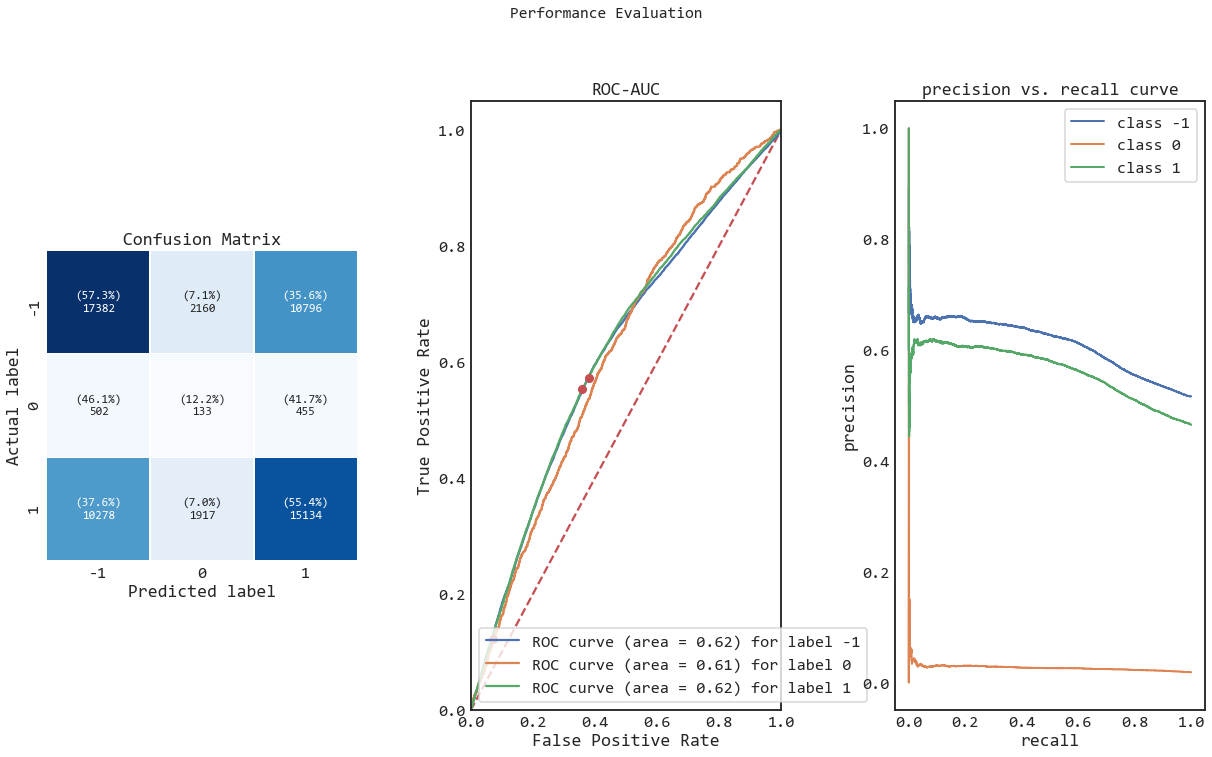

<IPython.core.display.Javascript object>

In [15]:
rf_clf, rf_clf_perf = run_rf_model(X_train, y_train, X_validate, y_validate)
agg_res["rf_multiclass_all_feat"] = format_results(rf_clf_perf)
agg_res

## BaggingClassifier

In [16]:
def run_bag_model(X_train_, y_train_, X_test_, y_test_):
    clf_base = DecisionTreeClassifier(
        criterion="entropy",
        max_features=1,
        class_weight="balanced",
        min_weight_fraction_leaf=0,
        random_state=RANDOM_STATE,
    )
    bag_clf = BaggingClassifier(
        base_estimator=clf_base,
        n_estimators=2000,
        max_features=0.05,
        max_samples=0.05,
        oob_score=True,
        n_jobs=-1,
        random_state=RANDOM_STATE,
    )

    bag_clf.fit(X_train_, y_train_)
    bag_clf_perf = performance_evaluation_report_multiclass(
        bag_clf,
        X_test_,
        y_test_,
        show_plot=True,
        show_pr_curve=True,
        average=None,
        labels=classes,
    )
    pprint(bag_clf_perf)
    return bag_clf, bag_clf_perf

<IPython.core.display.Javascript object>

{'accuracy': array([0.5066, 0.9814, 0.492 ]),
 'cohens_kappa': 0.038,
 'f1_score': array([0.1898, 0.    , 0.6299]),
 'mcc': 0.0684,
 'precision': array([0.6236,    nan, 0.4764]),
 'recall': array([0.1119, 0.    , 0.9293]),
 'specificity': array([0.9279, 1.    , 0.1118])}


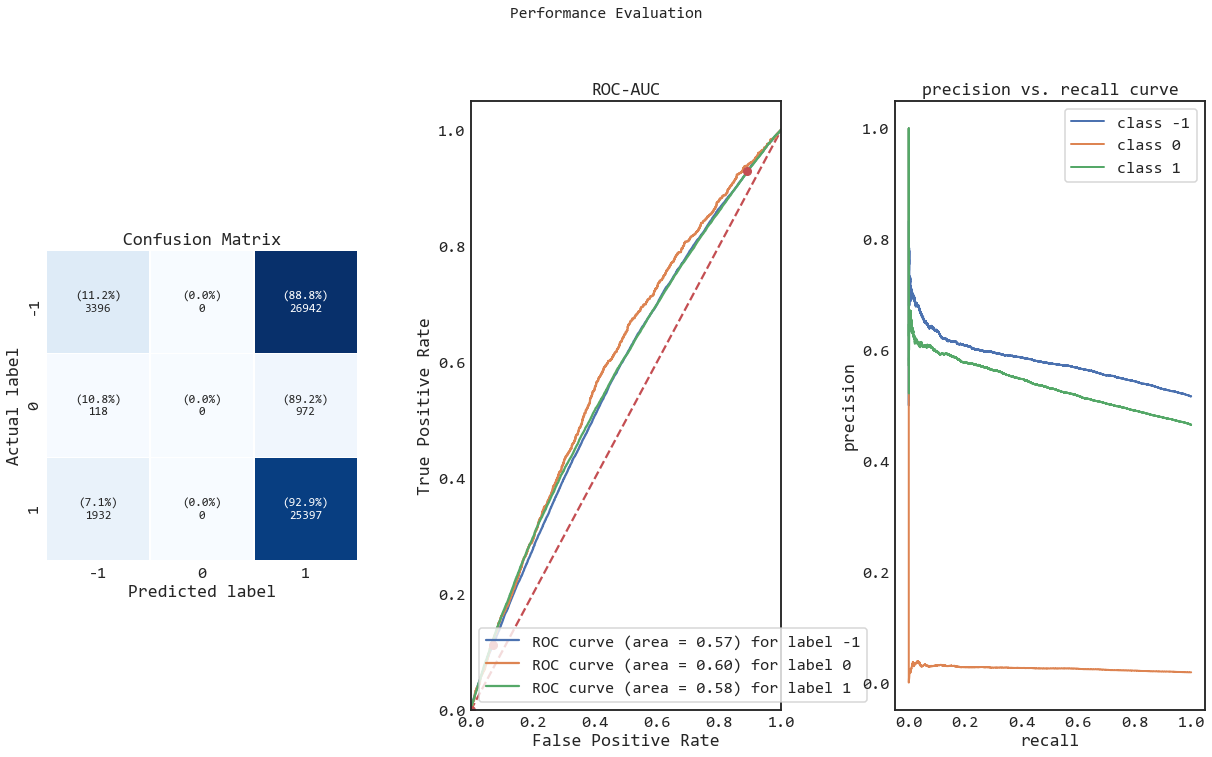

<IPython.core.display.Javascript object>

In [17]:
bag_clf, bag_clf_perf = run_bag_model(X_train, y_train, X_validate, y_validate)
agg_res["bag_multiclass_all_feat"] = format_results(bag_clf_perf)

## LightGBM

In [18]:
def run_gbm_model(X_train_, y_train_, X_test_, y_test_, best_params=None):
    if best_params is None:
        gbm = lgb.LGBMClassifier(
            boosting_type="dart",
            learning_rate=0.15,
            feature_fraction=0.7,
            bagging_fraction=0.7,
            n_estimators=2000,
            silent=True,
            n_jobs=-1,
            random_state=78,
            # predict_disable_shape_check=True,
        )
    else:
        gbm = lgb.LGBMClassifier(silent=True, n_jobs=-1, random_state=78, **best_params)

    gbm.fit(X_train_, y_train_)
    gbm_perf = performance_evaluation_report_multiclass(
        gbm,
        X_test_,
        y_test_,
        show_plot=True,
        show_pr_curve=True,
        average=None,
        labels=classes,
    )
    pprint(gbm_perf)
    return gbm, gbm_perf

<IPython.core.display.Javascript object>

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
{'accuracy': array([0.4903, 0.9814, 0.4724]),
 'cohens_kappa': 0.0107,
 'f1_score': array([0.0571, 0.    , 0.6338]),
 'mcc': 0.0365,
 'precision': array([0.6365, 0.    , 0.468 ]),
 'recall': array([0.0299, 0.    , 0.9817]),
 'specificity': array([0.9818, 1.    , 0.0295])}


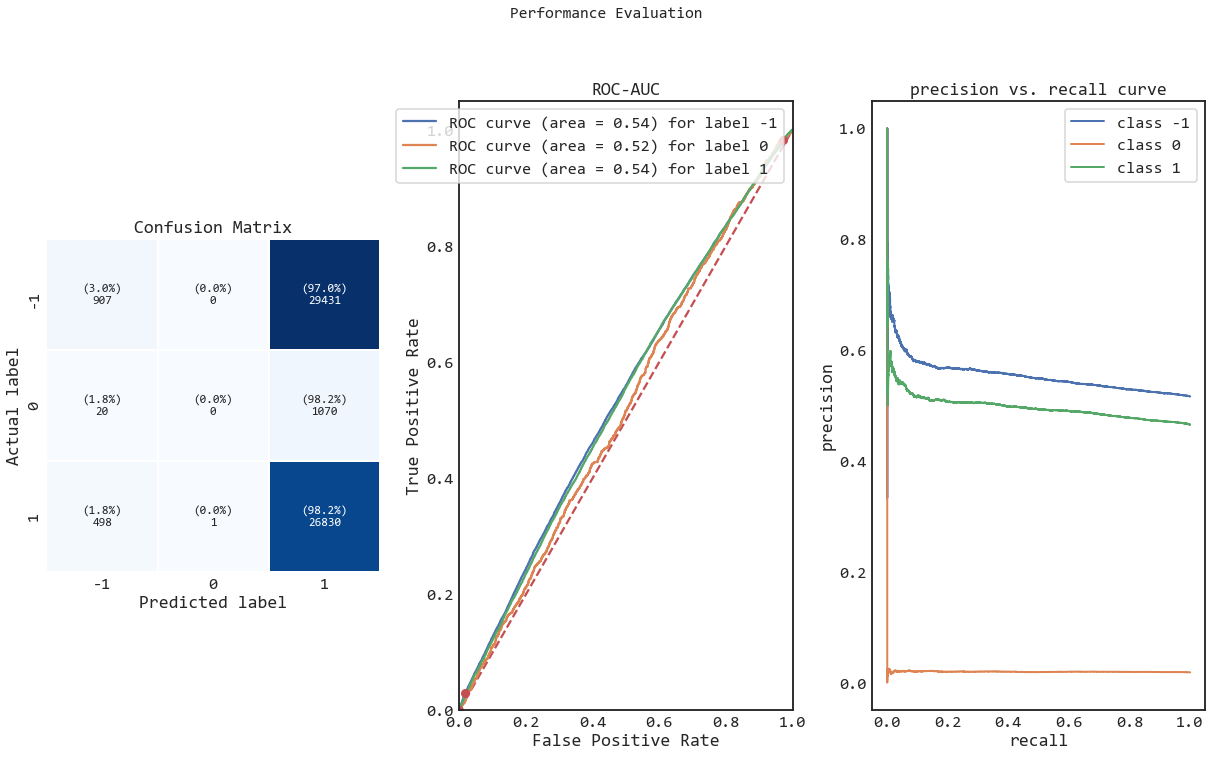

<IPython.core.display.Javascript object>

In [19]:
gbm, gbm_perf = run_gbm_model(X_train, y_train, X_validate, y_validate)
agg_res["gbm_multiclass_all_feat"] = format_results(gbm_perf)

RandomForest had the best non optimized performance. We will fit get Shap Features and rerun the experiment.

## Feature Selection

please note when using this much data the computation of the shap values took 1 hour and 45 minutes on my machine. it won't take nearly as long with the smaller datasets later on.

In [20]:
def shap_imp(clf, X):
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X)

    fi0 = np.abs(shap_values[0]).mean(axis=0)
    fi1 = np.abs(shap_values[1]).mean(axis=0)
    fi = fi0 + fi1
    imp = pd.DataFrame({"feature": X.columns.tolist(), "mean": fi})
    imp = imp.set_index("feature")

    return imp




<IPython.core.display.Javascript object>

In [21]:
# imp = shap_imp(rf_clf, X_train)  # takes almost 2 hours with this much data
"""imp = shap_imp(
    gbm_clf,
    X_train,
)"""

'imp = shap_imp(\n    gbm_clf,\n    X_train,\n)'

<IPython.core.display.Javascript object>

In [22]:
# top_shap_feat_ser = (
#    imp[(imp["mean"] > imp["mean"].mean())].squeeze().sort_values(ascending=False)
# )
# top_shap_feat_ser.plot.barh()

<IPython.core.display.Javascript object>

In [23]:
top_shap_feat = [
    "ibs",
    "rank_ibs_288",
    "up",
    "volume",
    "down",
    "rank_up_288",
    "racc_close_2880",
    "rvol_close_2880",
    "rsi_average_price_2880",
    "rsi_close_2880",
    "rvol_average_price_2880",
    "racc_average_price_2880",
    "rank_rvwap_2880_288",
    "rank_volume_288",
    "rank_average_price_288",
]
# top_shap_feat = top_shap_feat_ser.index.tolist()
top_shap_feat

['ibs',
 'rank_ibs_288',
 'up',
 'volume',
 'down',
 'rank_up_288',
 'racc_close_2880',
 'rvol_close_2880',
 'rsi_average_price_2880',
 'rsi_close_2880',
 'rvol_average_price_2880',
 'racc_average_price_2880',
 'rank_rvwap_2880_288',
 'rank_volume_288',
 'rank_average_price_288']

<IPython.core.display.Javascript object>

## Rerun RandomForest with Top Shap Features

I'm choosing the RandomForest model since it had the best performance out of the box so to speak

In [24]:
feature_cols = top_shap_feat  # .index

X_train, y_train = get_Xy(df_train, binary_outcomes, feature_cols, y_col)
cprint(X_train)
cprint(y_train)

X_validate, y_validate = get_Xy(df_validate, binary_outcomes, feature_cols, y_col)
cprint(X_validate)
cprint(y_validate)

X_test, y_test = get_Xy(df_test, binary_outcomes, feature_cols, y_col)
cprint(X_test)
cprint(y_test)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
                          ibs  rank_ibs_288      up  volume    down  \
datetime                                                              
2004-10-20 08:55:00  1.000000      0.000000  221600  579200  357600   
2004-10-20 09:00:00  0.818182      0.212544  169300  265500   96200   
2004-10-20 09:05:00  0.437500      0.526132  113000  294700  181700   
2004-10-20 09:10:00  0.800000      0.233449  109800  236200  126400   
2004-10-20 09:15:00  0.920000      0.125436  561700  746800  185100   

                     rank_up_288  racc_close_2880  rvol_close_2880  \
datetime                                                             
2004-10-20 08:55:00     0.536585         0.000984         0.000677   
2004-10-20 09:00:00     0.665505         0.000984         0.000677   
2004-10-20 09:05:00    

2019-05-14 12:30:00                0.543554  
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65939 entries, 2016-01-04 06:35:00 to 2019-05-14 12:30:00
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ibs                      65939 non-null  float64
 1   rank_ibs_288             65939 non-null  float64
 2   up                       65939 non-null  int64  
 3   volume                   65939 non-null  int64  
 4   down                     65939 non-null  int64  
 5   rank_up_288              65939 non-null  float64
 6   racc_close_2880          65939 non-null  float64
 7   rvol_close_2880          65939 non-null  float64
 8   rsi_average_price_2880   65939 non-null  float64
 9   rsi_close_2880           65939 non-null  float64
 10  rvol_average_price_2880  65939 non-null  float64
 11  racc_average_price_2880  65939 non-null  float64
 12

<IPython.core.display.Javascript object>

{'accuracy': array([0.5654, 0.6463, 0.5919]),
 'cohens_kappa': 0.1158,
 'f1_score': array([0.4811, 0.0507, 0.4833]),
 'mcc': 0.1335,
 'precision': array([0.6272, 0.0267, 0.5878]),
 'recall': array([0.3903, 0.5092, 0.4103]),
 'specificity': array([0.7523, 0.6489, 0.7498])}


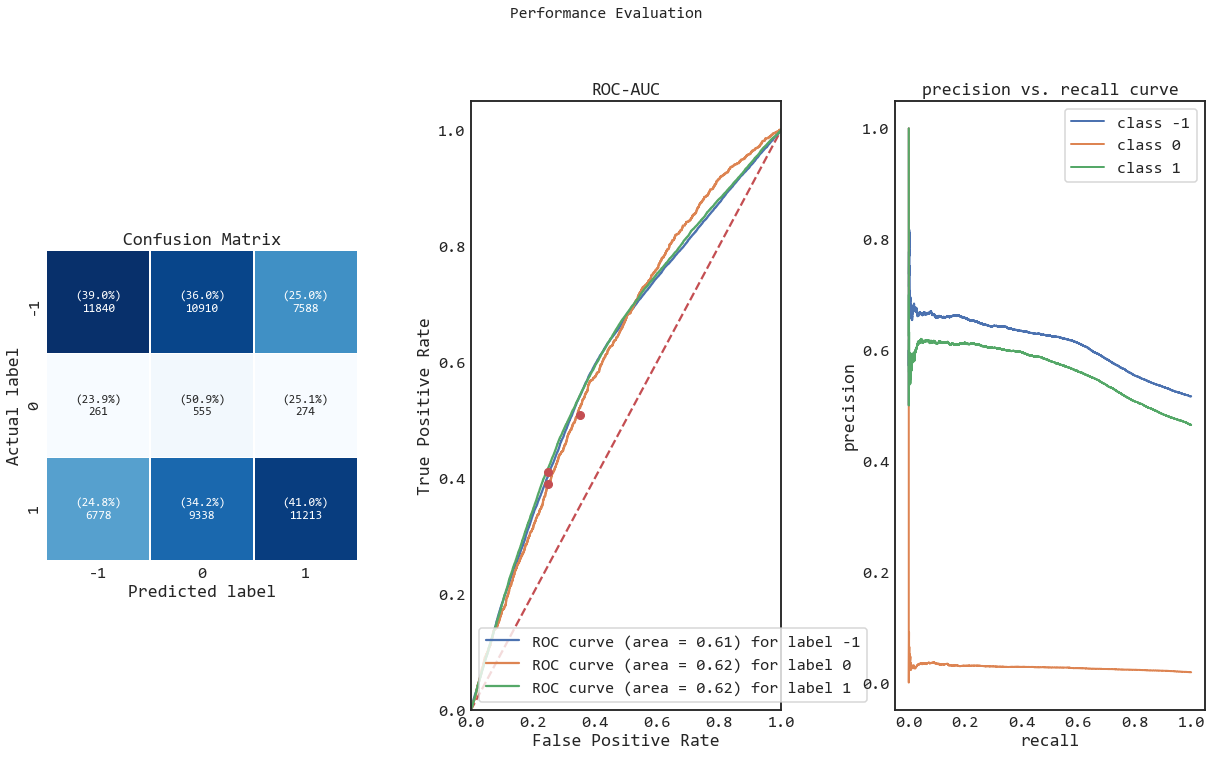

<IPython.core.display.Javascript object>

In [25]:
rf_clf_shap = RandomForestClassifier(
    criterion="entropy",
    max_depth=7,
    class_weight="balanced_subsample",
    n_estimators=512,
    random_state=42,
    oob_score=True,
    n_jobs=-1,
)

rf_clf_shap.fit(X_train, y_train)

rf_clf_shap_perf = performance_evaluation_report_multiclass(
    rf_clf_shap,
    X_validate,
    y_validate,
    show_plot=True,
    show_pr_curve=True,
    average=None,
    labels=classes,
)
pprint(rf_clf_shap_perf)
agg_res["rf_multiclass_shap_feat"] = format_results(rf_clf_shap_perf)

## Optimize with Neptune and Optuna, Use best parameters on hold out set

Please see the demo script **run_es_feature_hyperoptuna_randomforest.py**. For some reason it blows up the Juypter Notebook memory usage and crashes the Kernel.

{'accuracy': array([0.5094, 0.2416, 0.5562]),
 'cohens_kappa': 0.0319,
 'f1_score': array([0.2165, 0.0416, 0.2381]),
 'mcc': 0.0632,
 'precision': array([0.6168, 0.0213, 0.5908]),
 'recall': array([0.1313, 0.8862, 0.1491]),
 'specificity': array([0.9129, 0.2295, 0.9102])}


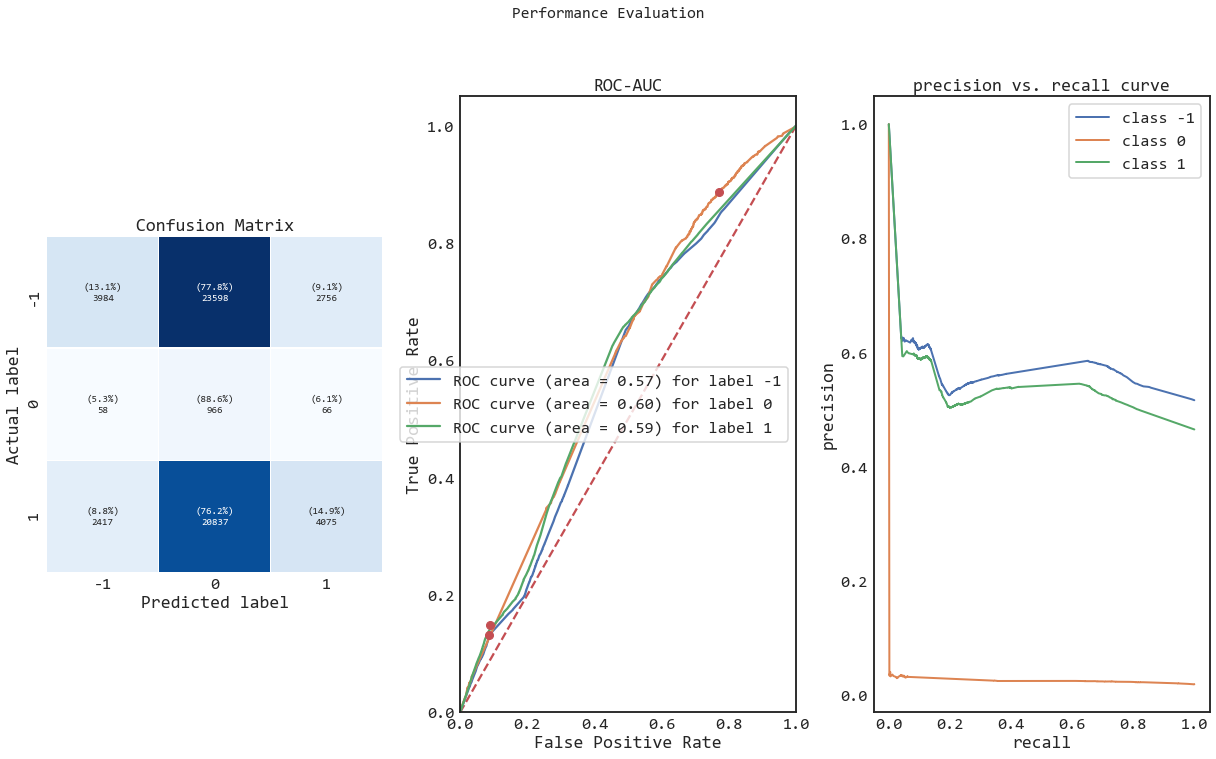

<IPython.core.display.Javascript object>

In [31]:
# get best params from neptune output and rerun

best_params = {
    "n_estimators": 600,
    "max_depth": 3,
    "min_samples_split": 0.42,
    "max_features": 0.98,
}

rf_clf_shap = RandomForestClassifier(
    criterion="entropy",
    class_weight="balanced_subsample",
    random_state=RANDOM_STATE,
    oob_score=True,
    n_jobs=-1,
    **best_params,
)

rf_clf_shap.fit(X_train, y_train)

rf_clf_shap_perf = performance_evaluation_report_multiclass(
    rf_clf_shap,
    X_validate,
    y_validate,
    show_plot=True,
    show_pr_curve=True,
    average=None,
    labels=classes,
)
pprint(rf_clf_shap_perf)
agg_res["rf_multiclass_shap_optuna"] = format_results(rf_clf_shap_perf)

{'accuracy': array([0.4881, 0.1216, 0.549 ]),
 'cohens_kappa': 0.0131,
 'f1_score': array([0.1075, 0.0358, 0.1252]),
 'mcc': 0.0386,
 'precision': array([0.6055, 0.0182, 0.5853]),
 'recall': array([0.059 , 0.9598, 0.0701]),
 'specificity': array([0.9579, 0.1072, 0.9576])}


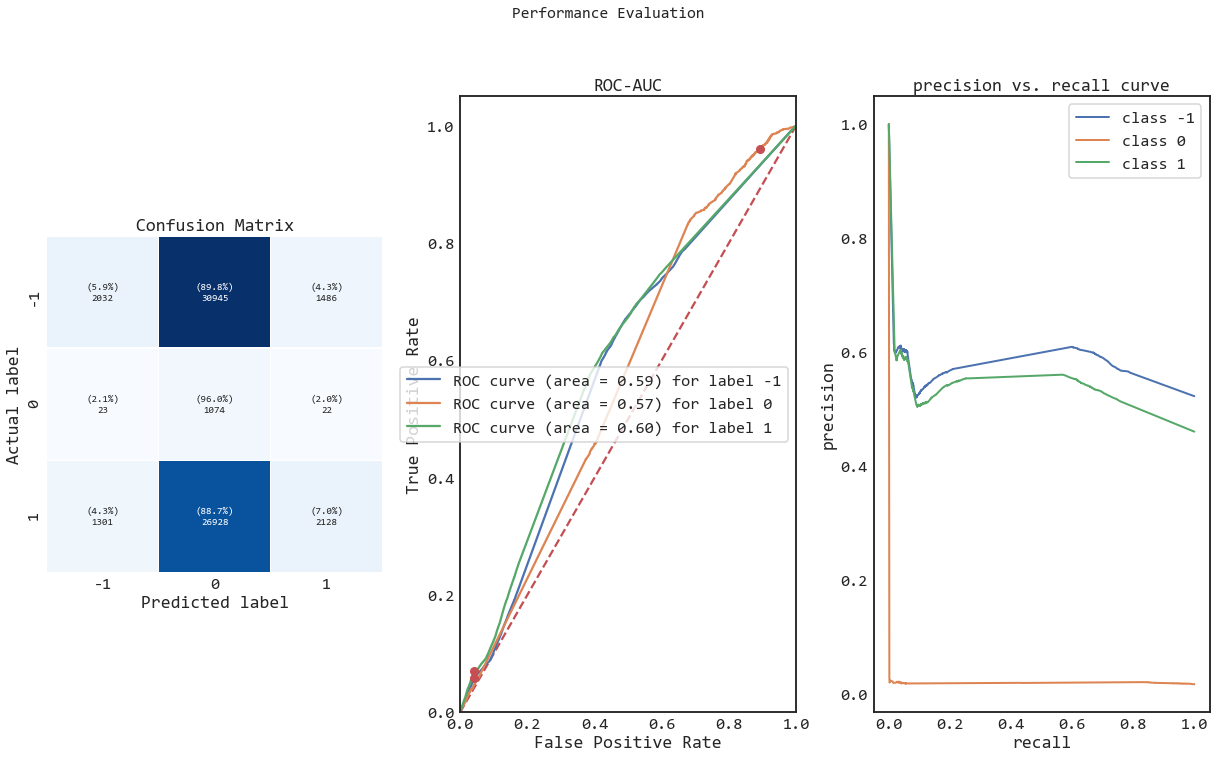

<IPython.core.display.Javascript object>

In [32]:
# does it generalize

rf_clf_shap_perf = performance_evaluation_report_multiclass(
    rf_clf_shap,
    X_test,
    y_test,
    show_plot=True,
    show_pr_curve=True,
    average=None,
    labels=classes,
)
pprint(rf_clf_shap_perf)
agg_res["rf_multiclass_shap_optuna_oos"] = format_results(rf_clf_shap_perf)

## Analysis

This first model generalizes well to unseen data in that the performance from the validation set carried over to the holdout set. 

`Pros`:
- true negatives are 18.6% better than the false negatives (top row, right corner). 
- true positives are 10.1% better than the false positives (bottom row, left corner).
- whenever a bet is misclassified as zero it's not ideal however it represents a bet not taken so it doesn't necessarily hurt us
- model setup and interpretation is straight forward and intuitive. 

`Cons`:
- unfortunately we can see that the true negatives and the true positives are less than 50%. 
- training takes a long time, as does optimization due to the size of the datasets.


In [33]:
# estimate performance


def get_raw_performance_estimate(
    clf, X: pd.DataFrame, return_series: pd.Series
) -> pd.DataFrame:
    estimate_rets = (
        np.exp(
            (
                # return_series.loc[X.index]
                # * clf.predict(X)
                return_series.reindex(X.index)
                * clf.predict(X)
                # * clf.predict_proba(X)[:, 1]
            ).cumsum()
        )
        * 100
    )

    estimate_perf = estimate_rets.calc_stats()
    display(estimate_perf.stats)
    estimate_perf.plot()
    return estimate_perf

<IPython.core.display.Javascript object>

In [34]:
y_col = Y_COL
y_col

'return_30'

<IPython.core.display.Javascript object>

start                    2013-01-02 06:35:00
end                      2015-12-31 13:00:00
rf                                  0.000000
total_return                     3872.168228
cagr                               14.715461
max_drawdown                       -0.058364
calmar                            252.131492
mtd                                 0.797476
three_month                         1.588359
six_month                           7.211436
ytd                                30.204508
one_year                           30.204508
three_year                         14.715461
five_year                                NaN
ten_year                                 NaN
incep                              14.715461
daily_sharpe                        8.796971
daily_sortino                      45.213736
daily_mean                          2.814864
daily_vol                           0.319981
daily_skew                          3.531082
daily_kurt                         22.612906
best_day  

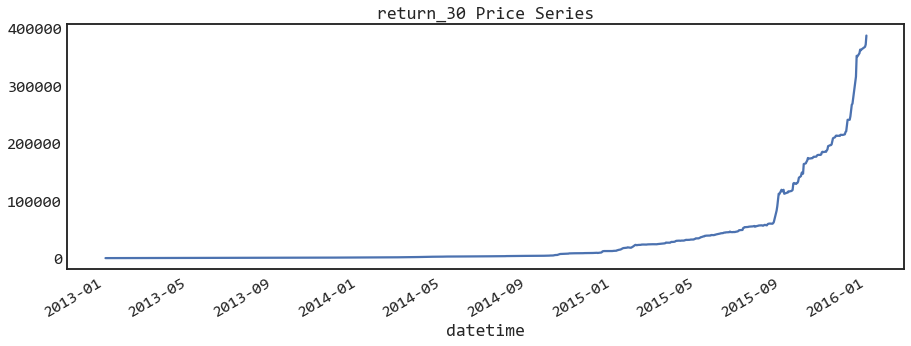

<IPython.core.display.Javascript object>

In [35]:
get_raw_performance_estimate(rf_clf_shap, X_validate, return_outcomes[y_col])

# MLFINLAB

In this section we use the information based data structures for several reasons:

- reduce the size of the data set
- improve the predictive power of the features (hopefully)

We also implement the triple barrier labeling method which incorporates asset volatility in setting the profit targets or stop losses for our labels. It also incorporates a time barrier which outputs a label zero if neither the profit target nor stop loss are hit before the time is up.

## Data Structures

In this section I only demonstrate the use of the dollar bar data structure. My results were better using  `ml.data_structures.get_const_dollar_imbalance_bars()` but I don't have enough intuition or understanding regarding the parameters to feel confident in using it at this time.

To recap quickly `Dollar Bars` are simply price bars that are created by sampling data after an equal amount of dollar volume is traded. In this experiment, that value is set to `$10 million USD`.

In [37]:
cprint(data)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
                       open    high     low   close      up    down  volume  \
datetime                                                                      
2004-08-27 12:25:00  111.51  111.53  111.47  111.50   40800   92800  133600   
2004-08-27 12:30:00  111.49  111.50  111.38  111.41  302500  338400  640900   
2004-08-27 12:35:00  111.40  111.49  111.40  111.48   86700  165400  252100   
2004-08-27 12:40:00  111.47  111.50  111.41  111.43  133000   86400  219400   
2004-08-27 12:45:00  111.43  111.43  111.33  111.38  207200  142400  349600   

                     average_price  rvwap_2880  upper_band_rvwap_2880  ...  \
datetime                                                               ...   
2004-08-27 12:25:00       111.5025  109.695769             111.932654  ...   
2004-08-27 12

<IPython.core.display.Javascript object>

Create the dollar bars

In [38]:
# dollar bars
dbars = ml.data_structures.get_dollar_bars(
    data.reset_index().rename(columns={"datetime": "date_time"}),
    threshold=1_000_000,
).set_index("date_time")
cprint(dbars)

Reading data in batches:
Batch number: 0
Returning bars 

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
                     tick_num    open    high     low   close   volume  \
date_time                                                                
2004-08-30 12:35:00        82  111.51  111.51  110.72  110.75  9108.04   
2004-08-31 12:50:00       164  110.77  110.96  110.12  110.96  9061.37   
2004-09-01 13:00:00       245  110.90  111.55  110.85  111.28  9013.89   
2004-09-03 06:35:00       326  111.24  112.59  111.24  112.41  9050.12   
2004-09-07 06:40:00       406  112.41  112.77  112.04  112.77  8987.56   

                     cum_buy_volume  cum_ticks  cum_dollar_value  
date_time                                                         
2004-08-30 12:35:00         4109.90         82      1.011402e+06  
2004-08-31 12:50:00    

<IPython.core.display.Javascript object>

Create the feature matrix `X` by joining the rest of the feature data from `data` with `dbars`.

In [39]:
X = (
    dbars.join(
        data.drop(["open", "high", "low", "close", "volume"], axis=1), how="left"
    )
    .drop_duplicates()
    .dropna()
)
cprint(X)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
                     tick_num    open    high     low   close   volume  \
date_time                                                                
2004-10-21 08:25:00      2955  110.43  111.21  110.19  111.05  9074.88   
2004-10-22 08:40:00      3037  111.09  111.25  110.28  110.83  9095.16   
2004-10-25 09:00:00      3120  110.81  110.96  109.40  109.53  9148.86   
2004-10-26 09:20:00      3203  109.47  110.86  109.47  110.86  9141.39   
2004-10-27 09:30:00      3284  110.84  112.36  110.82  112.34  9029.03   

                     cum_buy_volume  cum_ticks  cum_dollar_value      up  ...  \
date_time                                                                 ...   
2004-10-21 08:25:00         4982.60         82      1.003665e+06  331000  ...   
2004-10-22 08:40:00         4771.00    

<IPython.core.display.Javascript object>

In [40]:
df_train = X.loc[:"2012"]
df_validate = X.loc["2013":"2015"]
df_test = X.loc["2016":]

<IPython.core.display.Javascript object>

## Labeling

In [41]:
def calc_bins(in_data, n_days=1, pt=1, sl=2, min_ret=0.005, vol_lookback=22.0):

    daily_vol = ml.util.get_daily_vol(close=in_data["close"], lookback=vol_lookback)
    cusum_events = ml.filters.cusum_filter(
        in_data["close"], threshold=daily_vol.mean() * 0.5
    )

    t_events = cusum_events
    vertical_barriers = ml.labeling.add_vertical_barrier(
        t_events=t_events, close=in_data["close"], num_days=n_days
    )

    pt_sl = [pt, sl]

    triple_barrier_events = ml.labeling.get_events(
        close=in_data["close"],
        t_events=t_events,
        pt_sl=pt_sl,
        target=daily_vol,
        min_ret=min_ret,
        num_threads=10,
        vertical_barrier_times=vertical_barriers,
        side_prediction=None,
    )

    labels = ml.labeling.get_bins(triple_barrier_events, in_data["close"])

    print("**************************************")
    print(f"labels head:\n {labels.head()}")
    print(f"labels bin count:\n {labels.bin.value_counts()}")

    return labels, triple_barrier_events


def align_data_and_labels_indexes(in_X, in_labels, in_triple_barrier_events):
    out_triple_barrier_events = in_triple_barrier_events.loc[
        in_X.index.intersection(in_labels.index)
    ]
    out_X = in_X.loc[in_X.index.intersection(in_labels.index)]
    return out_X, out_triple_barrier_events

<IPython.core.display.Javascript object>

In [42]:
labels, triple_barrier_events = calc_bins(X, pt=1.25, sl=1, n_days=1)
X, triple_barrier_events = align_data_and_labels_indexes(
    X, labels, triple_barrier_events
)

2021-05-18 16:15:25.739358 100.0% apply_pt_sl_on_t1 done after 0.55 minutes. Remaining 0.0 minutes.


**************************************
labels head:
                           ret      trgt  bin
2004-10-25 09:00:00  0.012143  0.006893    1
2004-10-26 09:20:00  0.013350  0.012301    0
2004-10-27 09:30:00  0.005252  0.012059    0
2004-10-28 09:30:00  0.001771  0.012435    0
2004-11-01 09:25:00  0.012247  0.009812    0
labels bin count:
  0    1862
-1     564
 1     396
Name: bin, dtype: int64


<IPython.core.display.Javascript object>

## Split data

In [43]:
feature_cols = X.columns.tolist()

y_col = "bin"
X_train, y_train = get_Xy(df_train, labels, feature_cols, y_col)
cprint(X_train)
cprint(y_train)

X_validate, y_validate = get_Xy(df_validate, labels, feature_cols, y_col)
cprint(X_validate)
cprint(y_validate)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
                     tick_num    open    high     low   close   volume  \
date_time                                                                
2004-10-25 09:00:00      3120  110.81  110.96  109.40  109.53  9148.86   
2004-10-26 09:20:00      3203  109.47  110.86  109.47  110.86  9141.39   
2004-10-27 09:30:00      3284  110.84  112.36  110.82  112.34  9029.03   
2004-10-28 09:30:00      3363  112.29  113.14  112.16  112.93  8912.44   
2004-11-01 09:25:00      3520  113.08  113.79  113.04  113.50  8843.75   

                     cum_buy_volume  cum_ticks  cum_dollar_value      up  ...  \
date_time                                                                 ...   
2004-10-25 09:00:00         4078.15         83      1.007931e+06  374400  ...   
2004-10-26 09:20:00         4958.01    

<IPython.core.display.Javascript object>

## RandomForest

{'accuracy': array([0.7246, 0.6312, 0.8357]),
 'cohens_kappa': 0.0698,
 'f1_score': array([0.24  , 0.7497, 0.    ]),
 'mcc': 0.0797,
 'precision': array([0.2647, 0.6609,    nan]),
 'recall': array([0.2195, 0.8662, 0.    ]),
 'specificity': array([0.8494, 0.2178, 1.    ])}


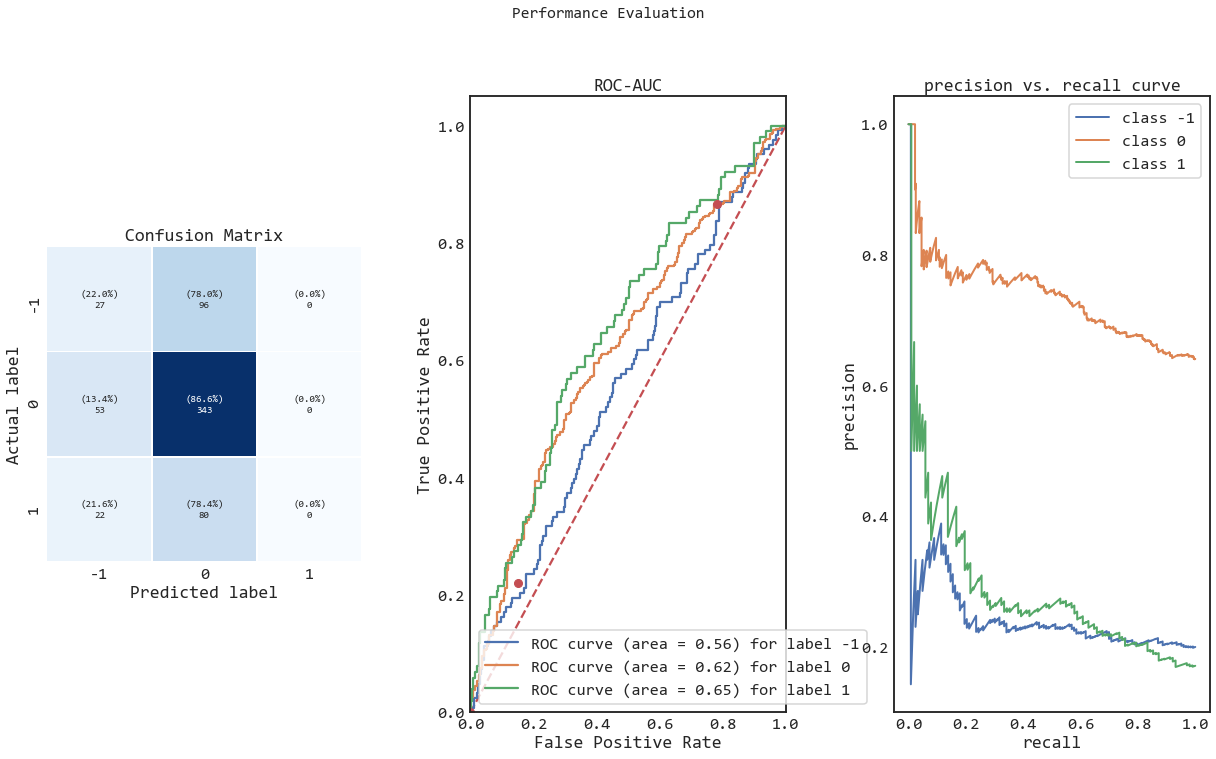

<IPython.core.display.Javascript object>

In [44]:
rf_clf, rf_clf_perf = run_rf_model(X_train, y_train, X_validate, y_validate)
agg_res["rf_dbars_all_feat"] = format_results(rf_clf_perf)

## Bagging Classifier

{'accuracy': array([0.8019, 0.6377, 0.8357]),
 'cohens_kappa': 0.0,
 'f1_score': array([0.    , 0.7788, 0.    ]),
 'mcc': 0.0,
 'precision': array([   nan, 0.6377,    nan]),
 'recall': array([0., 1., 0.]),
 'specificity': array([1., 0., 1.])}


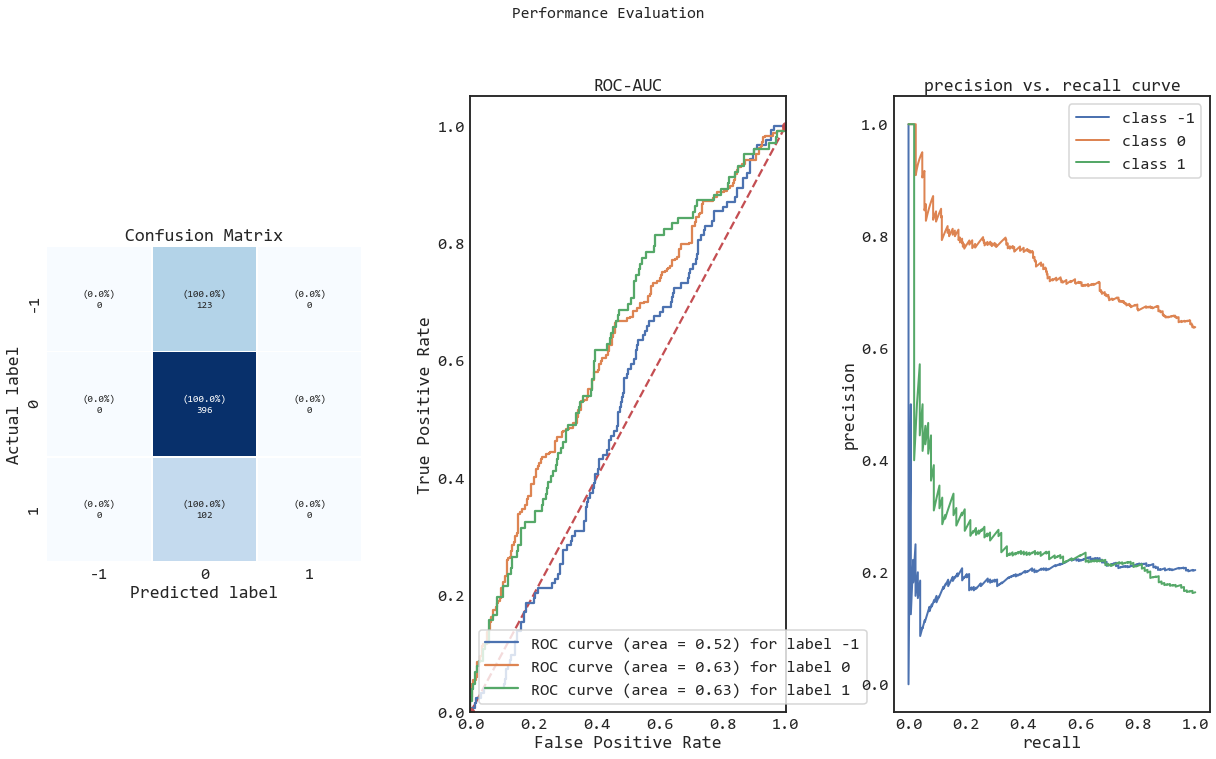

<IPython.core.display.Javascript object>

In [45]:
bag_clf, bag_clf_perf = run_bag_model(X_train, y_train, X_validate, y_validate)
agg_res["bag_dbars_all_feat"] = format_results(bag_clf_perf)

## LightGBM

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
{'accuracy': array([0.7037, 0.6039, 0.81  ]),
 'cohens_kappa': 0.0636,
 'f1_score': array([0.2269, 0.7159, 0.1449]),
 'mcc': 0.0661,
 'precision': array([0.2348, 0.6596, 0.2778]),
 'recall': array([0.2195, 0.7828, 0.098 ]),
 'specificity': array([0.8233, 0.2889, 0.9499])}


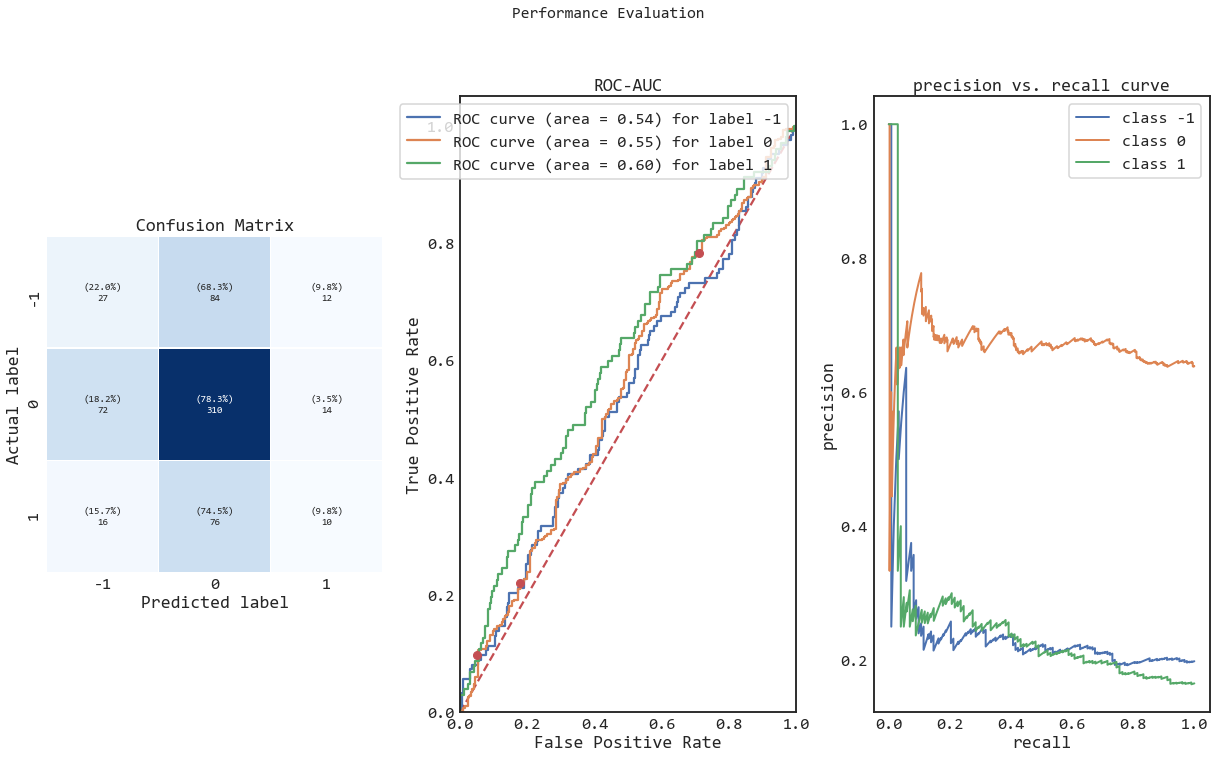

<IPython.core.display.Javascript object>

In [46]:
gbm, gbm_perf = run_gbm_model(X_train, y_train, X_validate, y_validate)
agg_res["gbm_dbars_all_feat"] = format_results(gbm_perf)

LightGBM is the only model that predicted the positive class at all.

## Feature Selection

In [47]:
def shap_imp(clf, X):
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X)

    fi0 = np.abs(shap_values[0]).mean(axis=0)
    fi1 = np.abs(shap_values[1]).mean(axis=0)
    fi = fi0 + fi1
    imp = pd.DataFrame({"feature": X.columns.tolist(), "mean": fi})
    imp = imp.set_index("feature")

    return imp


def get_top_shap_feat(imp, plot=True):
    top_shap_feat = (
        imp[(imp["mean"] > imp["mean"].mean())].squeeze().sort_values(ascending=False)
    )
    if plot:
        top_shap_feat.plot.barh(figsize=(6, 7))
    return top_shap_feat

<IPython.core.display.Javascript object>

#### gbm feat select

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
              mean
feature           
tick_num  0.203079
open      0.265876
high      0.113948
low       0.136270
close     0.127998
-------------------------
TAIL num rows: 5
                                        mean
feature                                     
rank_rvol_average_price_2880_288    0.206793
rank_rsi_close_2880_288             0.695421
rank_rsi_average_price_2880_288     0.204465
rank_racorr_close_2880_288          0.531184
rank_racorr_average_price_2880_288  0.837347
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, tick_num to rank_racorr_average_price_2880_288
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mean    60 non-null     float64
dtypes: floa

feature
rank_average_price_288                       1.156150
slope_upper_band_rvwap_2880_2880             0.855791
rank_racorr_average_price_2880_288           0.837347
racorr_close_2880                            0.831685
cum_dollar_value                             0.827361
rank_rsi_close_2880_288                      0.695421
rank_up_288                                  0.678499
rank_racc_rvwap_2880_2880_288                0.673708
cum_buy_volume                               0.641730
slope_rmax_high_2880_2880                    0.633115
racorr_average_price_2880                    0.608067
rank_down_288                                0.593752
rank_aqr_momo_average_price_2880_288         0.558352
rank_racorr_close_2880_288                   0.531184
rank_slope_upper_band_rvwap_2880_2880_288    0.527157
rank_volume_288                              0.521310
slope_rmin_low_2880_2880                     0.491446
ibs                                          0.481366
up                  

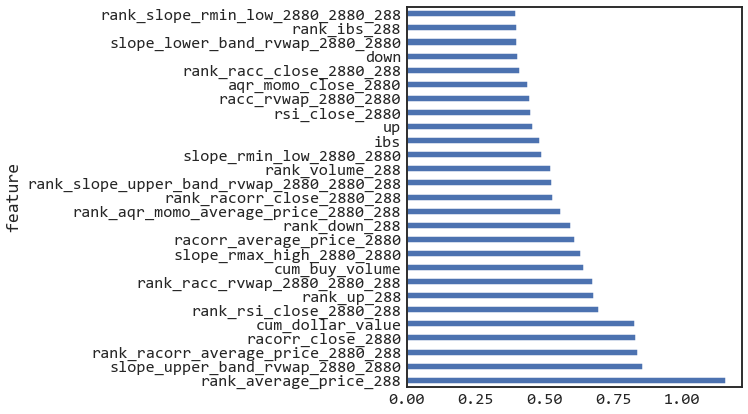

<IPython.core.display.Javascript object>

In [48]:
gbm_imp = shap_imp(gbm, X_train)
cprint(gbm_imp)

gbm_tsf = get_top_shap_feat(gbm_imp)
gbm_tsf

#### rf top shap feat

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
              mean
feature           
tick_num  0.004393
open      0.004488
high      0.003476
low       0.003915
close     0.004339
-------------------------
TAIL num rows: 5
                                        mean
feature                                     
rank_rvol_average_price_2880_288    0.004053
rank_rsi_close_2880_288             0.009346
rank_rsi_average_price_2880_288     0.009774
rank_racorr_close_2880_288          0.008496
rank_racorr_average_price_2880_288  0.013883
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, tick_num to rank_racorr_average_price_2880_288
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mean    60 non-null     float64
dtypes: floa

feature
rank_average_price_288                       0.044011
rank_slope_upper_band_rvwap_2880_2880_288    0.014803
rank_racorr_average_price_2880_288           0.013883
cum_buy_volume                               0.011368
rank_ibs_288                                 0.010413
rank_rsi_average_price_2880_288              0.009774
rank_rsi_close_2880_288                      0.009346
aqr_momo_close_2880                          0.009163
aqr_momo_average_price_2880                  0.008681
ibs                                          0.008646
rsi_close_2880                               0.008532
rank_racorr_close_2880_288                   0.008496
cum_dollar_value                             0.008096
rsi_average_price_2880                       0.007972
racc_average_price_2880                      0.007841
rank_slope_rmin_low_2880_2880_288            0.007651
racorr_average_price_2880                    0.006840
racc_close_2880                              0.006458
rvol_average_price_2

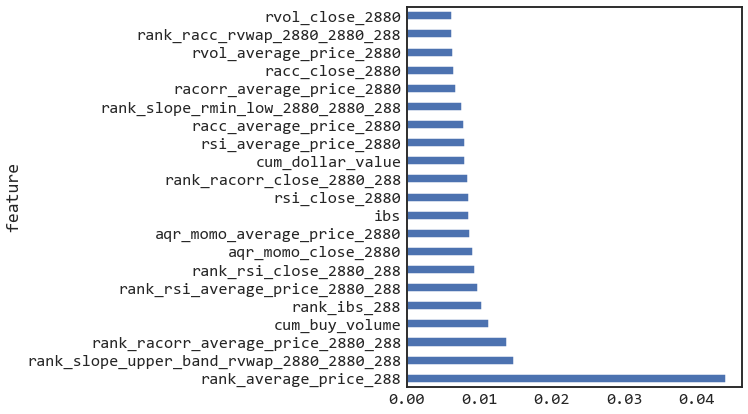

<IPython.core.display.Javascript object>

In [49]:
rf_imp = shap_imp(rf_clf, X_train)
cprint(rf_imp)

rf_tsf = get_top_shap_feat(rf_imp)
rf_tsf

In [50]:
rf_tsf.index.tolist()

['rank_average_price_288',
 'rank_slope_upper_band_rvwap_2880_2880_288',
 'rank_racorr_average_price_2880_288',
 'cum_buy_volume',
 'rank_ibs_288',
 'rank_rsi_average_price_2880_288',
 'rank_rsi_close_2880_288',
 'aqr_momo_close_2880',
 'aqr_momo_average_price_2880',
 'ibs',
 'rsi_close_2880',
 'rank_racorr_close_2880_288',
 'cum_dollar_value',
 'rsi_average_price_2880',
 'racc_average_price_2880',
 'rank_slope_rmin_low_2880_2880_288',
 'racorr_average_price_2880',
 'racc_close_2880',
 'rvol_average_price_2880',
 'rank_racc_rvwap_2880_2880_288',
 'rvol_close_2880']

<IPython.core.display.Javascript object>

## Get Feature Matrix and targets for train validate test splits

In [51]:
def make_model_datasets(feature_cols, df_train_, df_validate_, df_test_, y_col):

    X_train, y_train = get_Xy(df_train_, labels, feature_cols, y_col)

    X_validate, y_validate = get_Xy(df_validate_, labels, feature_cols, y_col)

    X_test, y_test = get_Xy(df_test_, labels, feature_cols, y_col)

    return X_train, y_train, X_validate, y_validate, X_test, y_test

<IPython.core.display.Javascript object>

#### gbm datatsets

In [52]:
(
    gbm_X_train,
    gbm_y_train,
    gbm_X_validate,
    gbm_y_validate,
    gbm_X_test,
    gbm_y_test,
) = make_model_datasets(gbm_tsf.index, df_train, df_validate, df_test, y_col="bin")

<IPython.core.display.Javascript object>

#### rf datasets

In [53]:
(
    rf_X_train,
    rf_y_train,
    rf_X_validate,
    rf_y_validate,
    rf_X_test,
    rf_y_test,
) = make_model_datasets(rf_tsf.index, df_train, df_validate, df_test, y_col="bin")

<IPython.core.display.Javascript object>

### RandomForest

{'accuracy': array([0.7327, 0.6151, 0.7858]),
 'cohens_kappa': 0.1367,
 'f1_score': array([0.2523, 0.711 , 0.3109]),
 'mcc': 0.1376,
 'precision': array([0.2828, 0.6821, 0.3297]),
 'recall': array([0.2276, 0.7424, 0.2941]),
 'specificity': array([0.8574, 0.3911, 0.8825])}


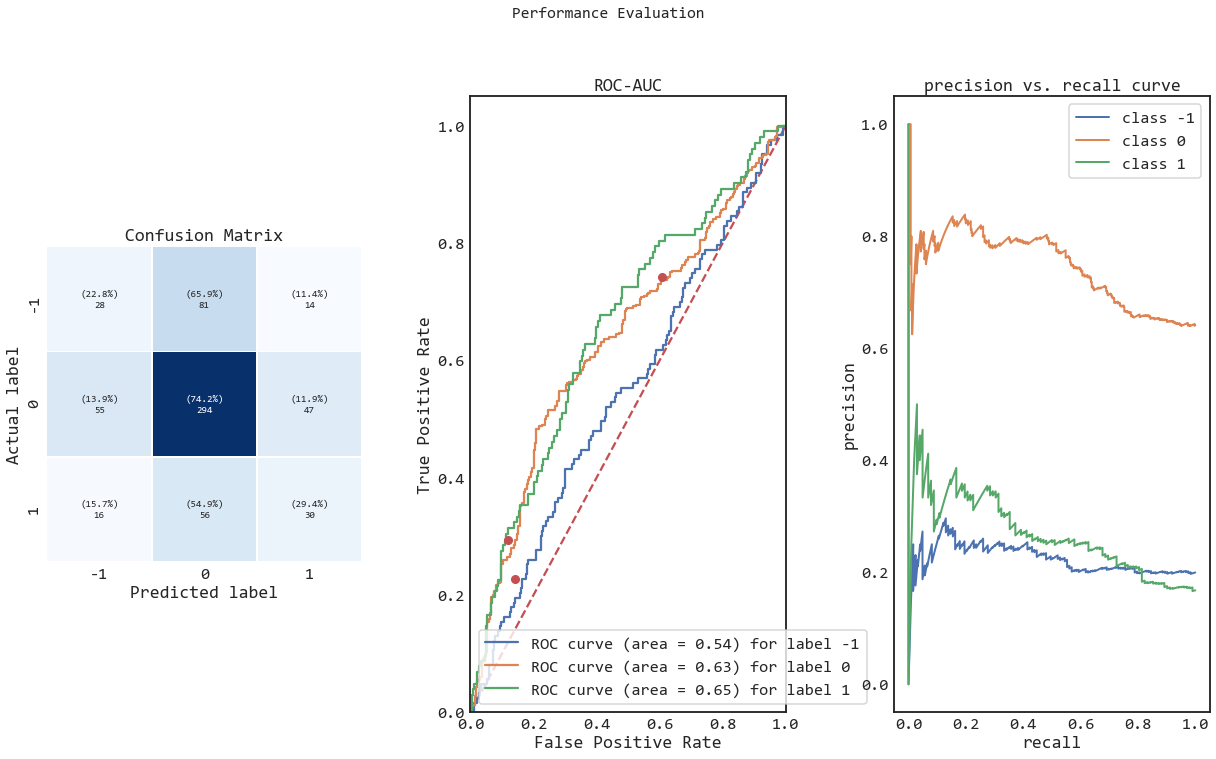

<IPython.core.display.Javascript object>

In [54]:
rf_clf, rf_perf = run_rf_model(
    rf_X_train,
    rf_y_train,
    rf_X_validate,
    rf_y_validate,
)

agg_res["rf_dbars_shap_feat"] = format_results(rf_perf)

### Bagging Classifier

{'accuracy': array([0.8019, 0.6377, 0.8357]),
 'cohens_kappa': 0.0,
 'f1_score': array([0.    , 0.7788, 0.    ]),
 'mcc': 0.0,
 'precision': array([   nan, 0.6377,    nan]),
 'recall': array([0., 1., 0.]),
 'specificity': array([1., 0., 1.])}


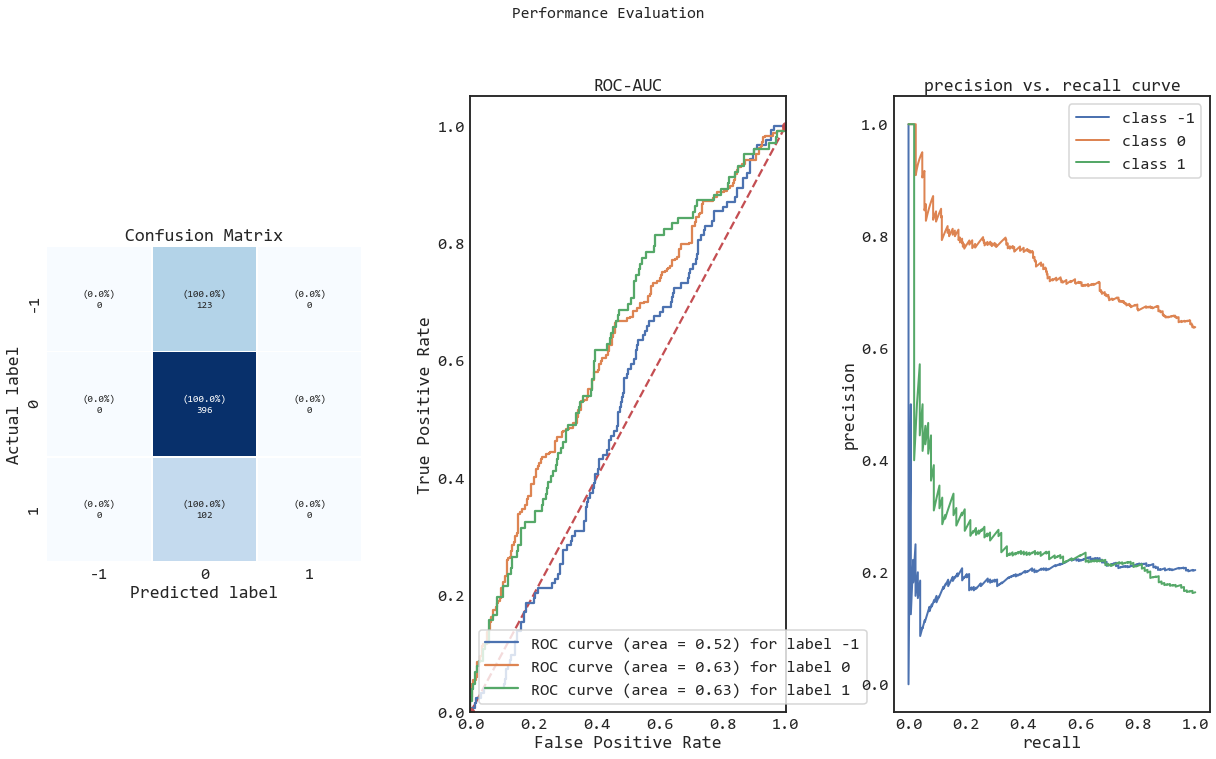

<IPython.core.display.Javascript object>

In [55]:
bag_clf, bag_perf = run_bag_model(X_train, y_train, X_validate, y_validate)
agg_res["bag_dbars_shap_feat"] = format_results(bag_perf)

### LightGBM Classifier

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
{'accuracy': array([0.7552, 0.6345, 0.8277]),
 'cohens_kappa': 0.075,
 'f1_score': array([0.1739, 0.7567, 0.144 ]),
 'mcc': 0.089,
 'precision': array([0.2623, 0.6574, 0.3913]),
 'recall': array([0.1301, 0.8914, 0.0882]),
 'specificity': array([0.9096, 0.1822, 0.973 ])}


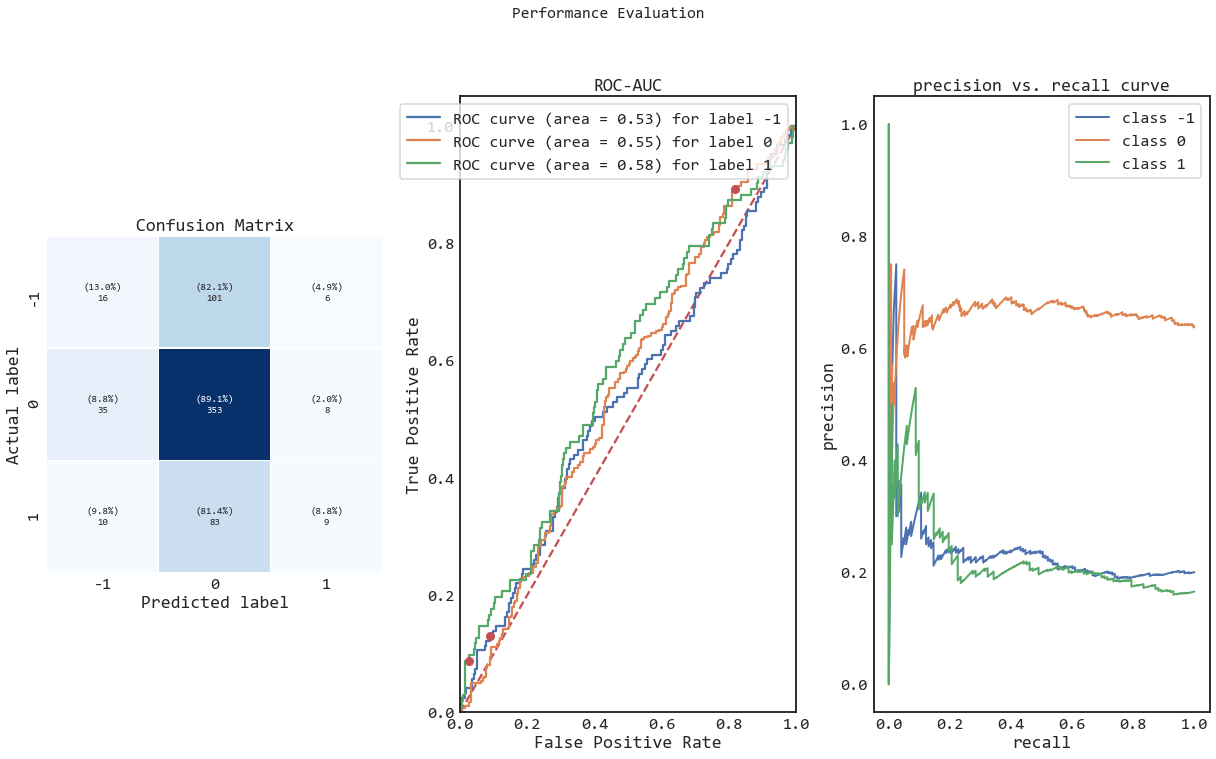

<IPython.core.display.Javascript object>

In [56]:
gbm_clf, gbm_perf = run_gbm_model(
    gbm_X_train,
    gbm_y_train,
    gbm_X_validate,
    gbm_y_validate,
)
agg_res["gbm_dbars_shap_feat"] = format_results(gbm_perf)

The Random Forest Classifier outperforms again. Let's run the optimization and see if we can improve the performance.

### Optimize with Neptune and Optuna, Use best parameters on hold out set

Please see the **run_es_feature_hyperoptuna_randomforest_mlfinlab.py** script that implements this portion. For some reason it blows up the Juypter Notebook memory usage and crashes the Kernel.

In [57]:
"""best_params = {
    "n_estimators": 1100,
    "max_depth": 4,
    "min_samples_split": 0.4556758308346775,
    "max_features": 0.6402713546524263,
}"""
# 1D 10 day
"""best_params = {
    "n_estimators": 1400,
    "max_depth": 8,
    "min_samples_split": 0.65,
    "max_features": 0.57,
}"""

# top shap feat
best_rf_params = {
    "n_estimators": 1300,
    "max_depth": 7,
    "min_samples_split": 0.11,
    "max_features": 0.61,
}

<IPython.core.display.Javascript object>

### best params from neptune hyperparameter opt

#### RF

{'accuracy': array([0.6216, 0.5604, 0.7005]),
 'cohens_kappa': 0.1603,
 'f1_score': array([0.3343, 0.5473, 0.3497]),
 'mcc': 0.1803,
 'precision': array([0.2565, 0.7971, 0.2717]),
 'recall': array([0.4797, 0.4167, 0.4902]),
 'specificity': array([0.6566, 0.8133, 0.7418])}


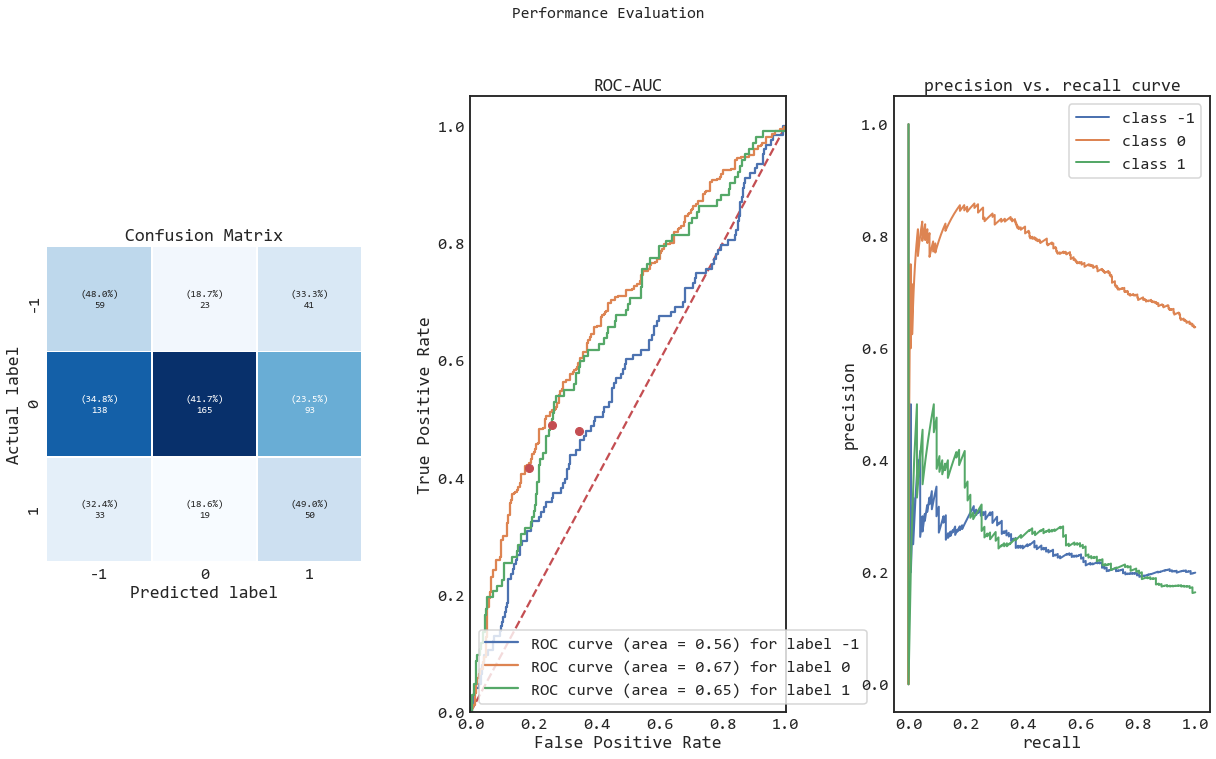

<IPython.core.display.Javascript object>

In [58]:
rf_val_clf, rf_val_perf = run_rf_model(
    rf_X_train, rf_y_train, rf_X_validate, rf_y_validate, params=best_rf_params
)
agg_res["rf_dbars_shap_optuna"] = format_results(rf_val_perf)

#### gbm

[LightGBM] [Warning] feature_fraction is set=0.82, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.82
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.95 will be ignored. Current value: bagging_fraction=1.0
{'accuracy': array([0.7601, 0.62  , 0.8341]),
 'cohens_kappa': 0.0177,
 'f1_score': array([0.1387, 0.7552, 0.019 ]),
 'mcc': 0.0246,
 'precision': array([0.24  , 0.6408, 0.3333]),
 'recall': array([0.0976, 0.9192, 0.0098]),
 'specificity': array([0.9237, 0.0933, 0.9961])}


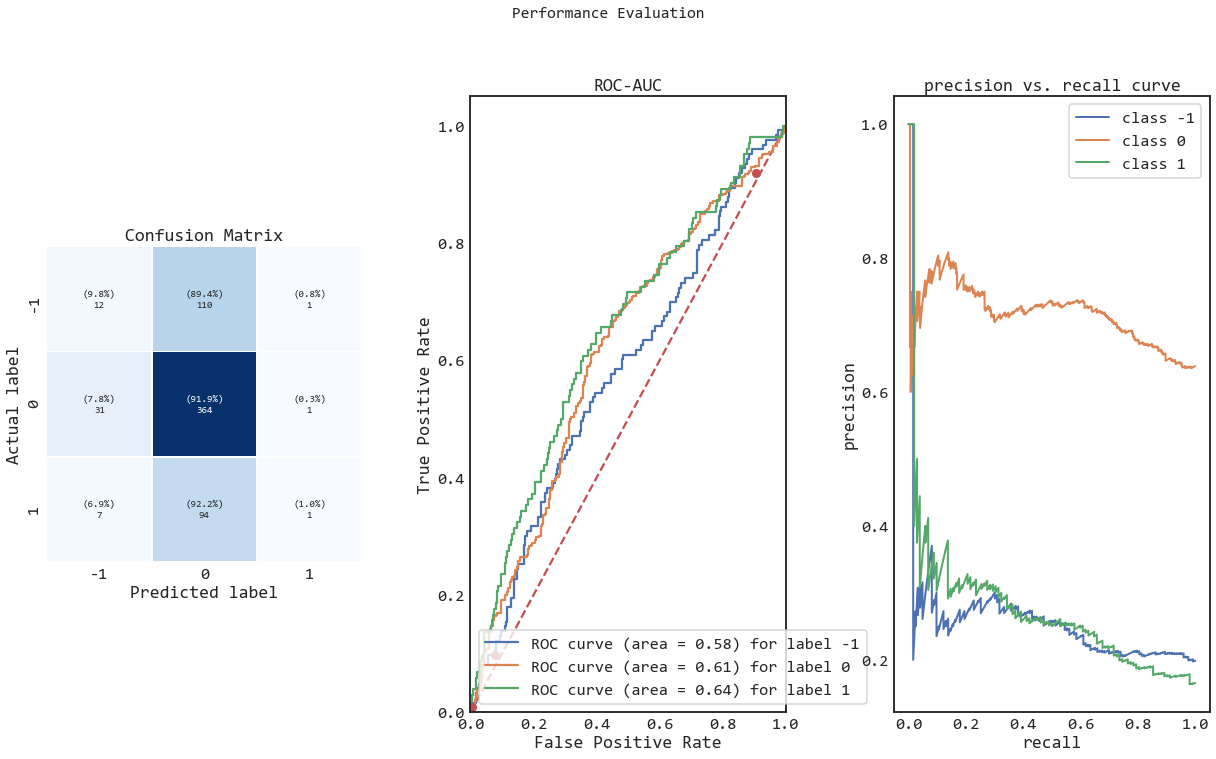

<IPython.core.display.Javascript object>

In [59]:
best_gbm_params = {
    "n_estimators": 1400,
    "max_depth": 21,
    "learning_rate": 0.7,
    "feature_fraction": 0.82,
    "bagging_fraction": 1.0,
    "colsample_bytree": 0.8,
    "num_leaves": 430,
    "reg_alpha": 1.34,
    "reg_lambda": 0.11,
    "min_split_gain": 0.75,
    "subsample": 0.95,
    "subsample_freq": 17,  # .36, now called bagging_freq and is integer?
    "boosting_type": "dart",
}

gbm_val_clf, gbm_val_perf = run_gbm_model(
    gbm_X_train,
    gbm_y_train,
    gbm_X_validate,
    gbm_y_validate,
    best_params=best_gbm_params,
)

agg_res["gbm_dbars_shap_optuna"] = format_results(gbm_val_perf)

#### RF - View Raw Backtest Performance Estimate

start                    2013-01-02 07:50:00
end                      2015-12-31 11:30:00
rf                                  0.000000
total_return                        0.412866
cagr                                0.122431
max_drawdown                       -0.234752
calmar                              0.521532
mtd                                 0.212721
three_month                         0.281769
six_month                           0.219376
ytd                                 0.231210
one_year                            0.231210
three_year                          0.122431
five_year                                NaN
ten_year                                 NaN
incep                               0.122431
daily_sharpe                        0.986165
daily_sortino                       1.576140
daily_mean                          0.217203
daily_vol                           0.220250
daily_skew                         -0.660545
daily_kurt                         42.754394
best_day  

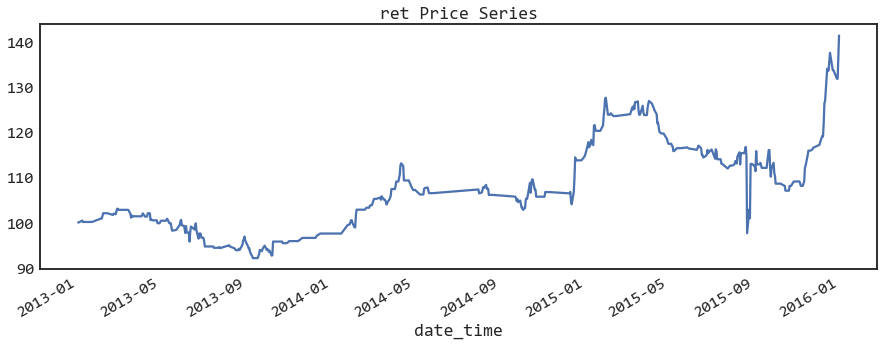

<IPython.core.display.Javascript object>

In [60]:
get_raw_performance_estimate(rf_val_clf, rf_X_validate, labels["ret"])
# get_raw_performance_estimate(rf_clf, X_validate, labels["ret"])

#### GBM - View Raw Backtest Performance Estimate

start                    2013-01-02 07:50:00
end                      2015-12-31 11:30:00
rf                                  0.000000
total_return                       -0.024821
cagr                               -0.008364
max_drawdown                       -0.043720
calmar                             -0.191306
mtd                                 0.002265
three_month                        -0.000516
six_month                          -0.008669
ytd                                -0.031124
one_year                           -0.031124
three_year                         -0.008364
five_year                                NaN
ten_year                                 NaN
incep                              -0.008364
daily_sharpe                       -0.320526
daily_sortino                      -0.439725
daily_mean                         -0.013169
daily_vol                           0.041087
daily_skew                         -0.558082
daily_kurt                         21.347176
best_day  

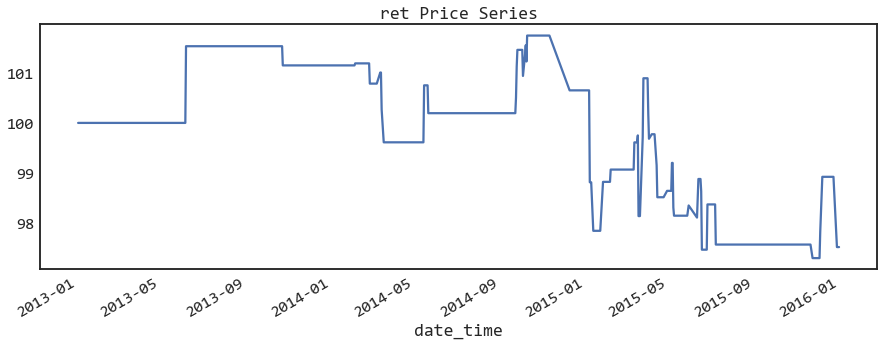

<IPython.core.display.Javascript object>

In [61]:
get_raw_performance_estimate(gbm_val_clf, gbm_X_validate, labels["ret"])

### RF - final test

{'accuracy': array([0.7536, 0.5531, 0.401 ]),
 'cohens_kappa': 0.0845,
 'f1_score': array([0.0208, 0.5079, 0.2871]),
 'mcc': 0.1207,
 'precision': array([0.2   , 0.7586, 0.1766]),
 'recall': array([0.011 , 0.3818, 0.7667]),
 'specificity': array([0.9862, 0.8146, 0.3328])}


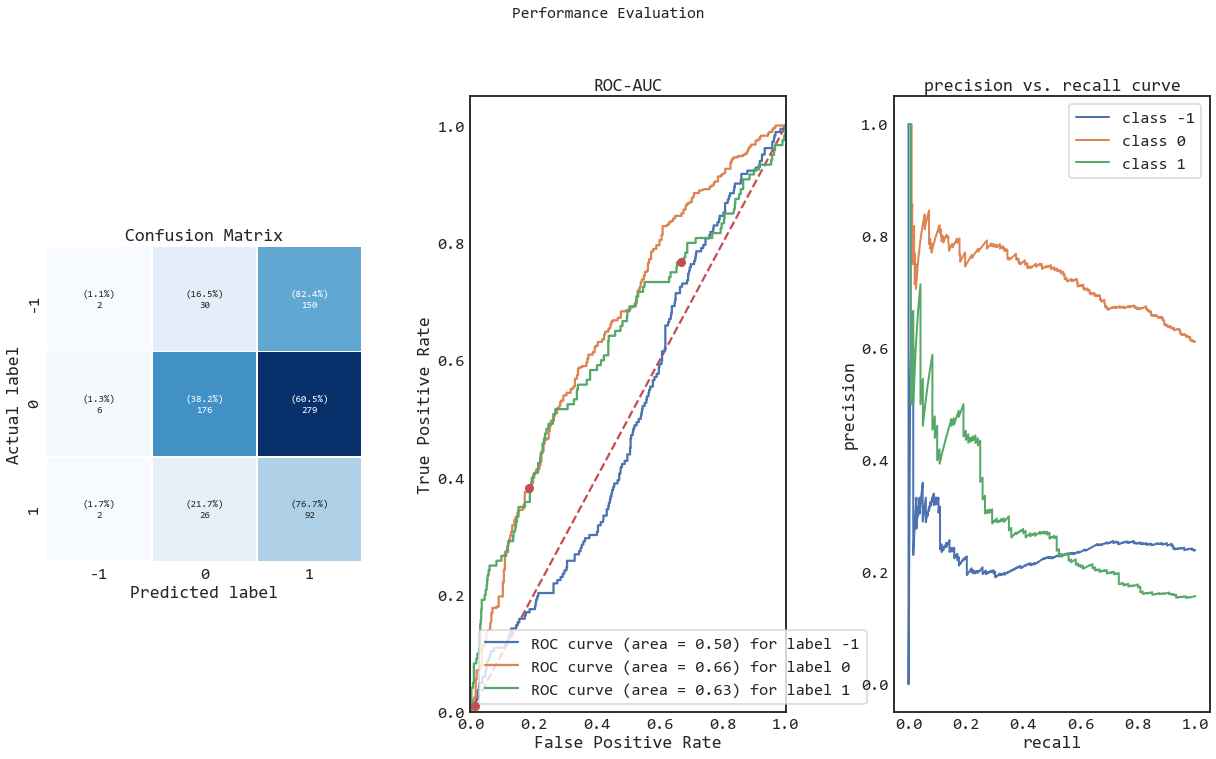

<IPython.core.display.Javascript object>

In [62]:
rf_test_clf, rf_test_perf = run_rf_model(
    rf_X_train, rf_y_train, rf_X_test, rf_y_test, params=best_params
)
agg_res["rf_dbars_shap_optuna_oos"] = format_results(rf_test_perf)

start                    2016-01-04 07:00:00
end                      2019-05-13 12:35:00
rf                                  0.000000
total_return                        0.010095
cagr                                0.002999
max_drawdown                       -0.358650
calmar                              0.008363
mtd                                -0.003103
three_month                         0.076665
six_month                           0.105830
ytd                                 0.267037
one_year                            0.049825
three_year                         -0.002114
five_year                           0.002999
ten_year                            0.002999
incep                               0.002999
daily_sharpe                        0.175791
daily_sortino                       0.262272
daily_mean                          0.054317
daily_vol                           0.308985
daily_skew                         -0.329234
daily_kurt                          6.901588
best_day  

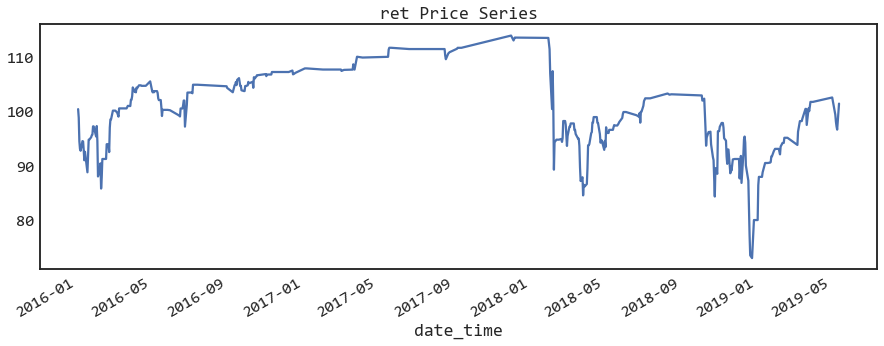

<IPython.core.display.Javascript object>

In [63]:
get_raw_performance_estimate(rf_test_clf, rf_X_test, labels["ret"])
# get_raw_performance_estimate(rf_clf, X_test, labels["ret"])

In [64]:
# persist model

"""outfile = processed / "rf_daily_model.pkl"
with open(outfile, "wb") as file:
    pickle.dump(rf_test_clf, file)"""

'outfile = processed / "rf_daily_model.pkl"\nwith open(outfile, "wb") as file:\n    pickle.dump(rf_test_clf, file)'

<IPython.core.display.Javascript object>

### GBM - final test

[LightGBM] [Warning] feature_fraction is set=0.82, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.82
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.95 will be ignored. Current value: bagging_fraction=1.0
{'accuracy': array([0.7366, 0.6042, 0.8414]),
 'cohens_kappa': 0.0236,
 'f1_score': array([0.0822, 0.7436, 0.062 ]),
 'mcc': 0.0393,
 'precision': array([0.2432, 0.6109, 0.4444]),
 'recall': array([0.0495, 0.9501, 0.0333]),
 'specificity': array([0.9518, 0.0762, 0.9922])}


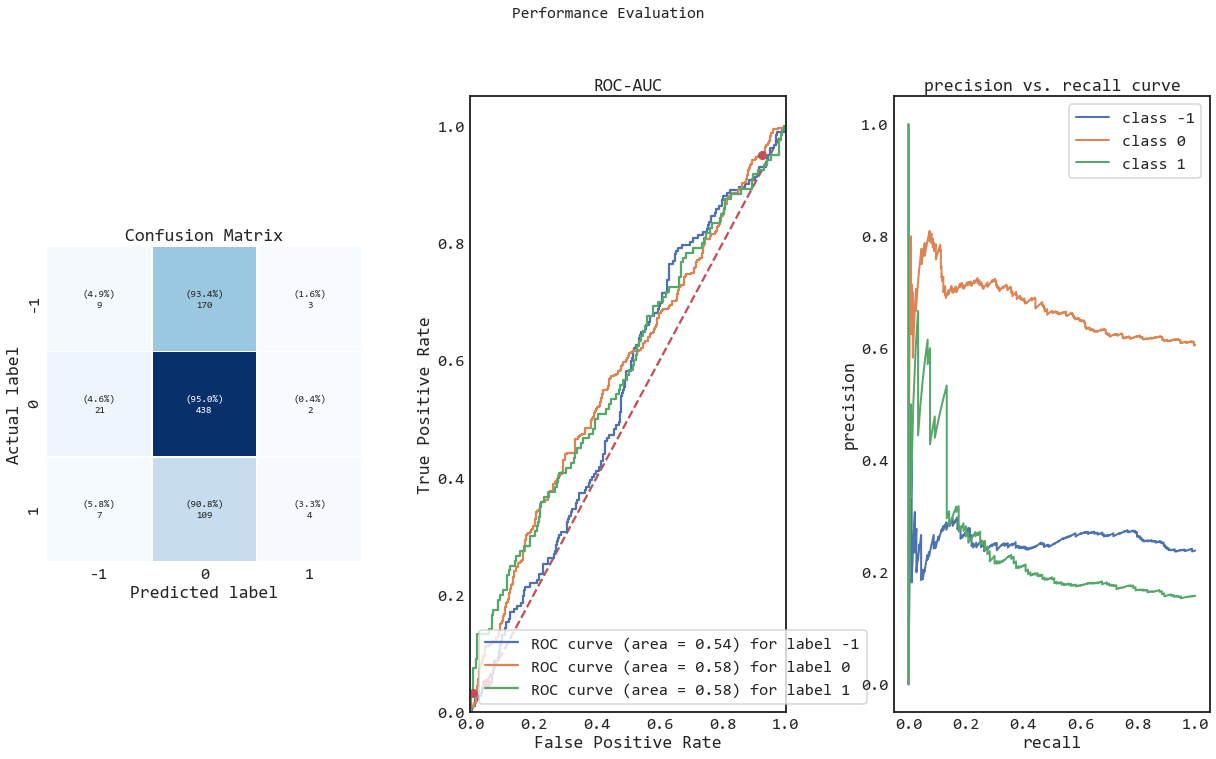

<IPython.core.display.Javascript object>

In [65]:
gbm_test_clf, gbm_test_perf = run_gbm_model(
    gbm_X_train, gbm_y_train, gbm_X_test, gbm_y_test, best_params=best_gbm_params
)
agg_res["gbm_dbars_shap_optuna_oos"] = format_results(gbm_test_perf)

start                    2016-01-04 07:00:00
end                      2019-05-13 12:35:00
rf                                  0.000000
total_return                       -0.043109
cagr                               -0.013053
max_drawdown                       -0.106967
calmar                             -0.122029
mtd                                 0.001352
three_month                         0.001352
six_month                           0.001352
ytd                                 0.001352
one_year                            0.038766
three_year                         -0.009702
five_year                          -0.013053
ten_year                           -0.013053
incep                              -0.013053
daily_sharpe                       -0.289504
daily_sortino                      -0.344882
daily_mean                         -0.024510
daily_vol                           0.084663
daily_skew                         -7.212741
daily_kurt                        114.387202
best_day  

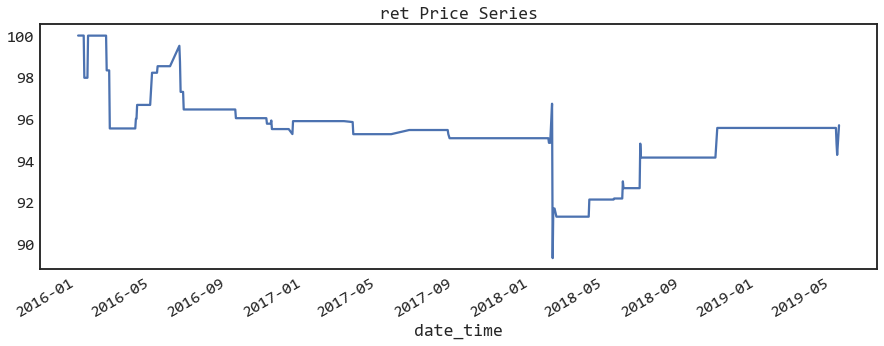

<IPython.core.display.Javascript object>

In [66]:
get_raw_performance_estimate(gbm_test_clf, gbm_X_test, labels["ret"])

## Analysis

`Pros`:
- RandomForest was able to balance the classes the best. 
- The model was able to generalize to the hold out data. 
- If you look at the parallel coordinates plot you can see that RandomForest was not too sensitive to the parameters.

`Cons`:
- The model was not able to distinguish the True negatives very well at all. 

# MLFINLAB with mixed timeframes

In this section we are going to use the same mlfinlab process except we're going to incorporate features from the `30 minute` time frame. And rerun the experiments.

## Import 30Min data

In [67]:
sym = "spy"
freq = "30m"
lookback = "10_day"
key = f"{sym}/{freq}/{lookback}"
print(key)

data2 = pd.read_hdf(infile, key=key)
cprint(data2)

spy/30m/10_day
-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
                       open    high     low   close       up     down  \
datetime                                                                
2004-08-23 10:00:00  110.36  110.46  110.24  110.34   654300   998500   
2004-08-23 10:30:00  110.34  110.61  110.30  110.59  1211300   505600   
2004-08-23 11:00:00  110.56  110.77  110.52  110.61   726500   758700   
2004-08-23 11:30:00  110.60  110.63  110.32  110.34   705300   984500   
2004-08-23 12:00:00  110.34  110.38  110.05  110.15  1445100  2048400   

                      volume  average_price   rvwap_480  upper_band_rvwap_480  \
datetime                                                                        
2004-08-23 10:00:00  1652800       110.3500  109.724712            111.877122   
2004-08-23 10:30:00  1716900   

<IPython.core.display.Javascript object>

## Split Datasets

In [68]:
df_train2 = data2.loc[:"2012"]
df_validate2 = data2.loc["2013":"2015"]
df_test2 = data2.loc["2016":]

<IPython.core.display.Javascript object>

## Join 5Min data features and 30Min data features

In [69]:
data_join = data.join(data2, how="left", rsuffix="_30m").ffill()
cprint(data_join)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
                       open    high     low   close      up    down  volume  \
datetime                                                                      
2004-08-27 12:25:00  111.51  111.53  111.47  111.50   40800   92800  133600   
2004-08-27 12:30:00  111.49  111.50  111.38  111.41  302500  338400  640900   
2004-08-27 12:35:00  111.40  111.49  111.40  111.48   86700  165400  252100   
2004-08-27 12:40:00  111.47  111.50  111.41  111.43  133000   86400  219400   
2004-08-27 12:45:00  111.43  111.43  111.33  111.38  207200  142400  349600   

                     average_price  rvwap_2880  upper_band_rvwap_2880  ...  \
datetime                                                               ...   
2004-08-27 12:25:00       111.5025  109.695769             111.932654  ...   
2004-08-27 12

<IPython.core.display.Javascript object>

In [70]:
pprint(data_join.columns.tolist())

['open',
 'high',
 'low',
 'close',
 'up',
 'down',
 'volume',
 'average_price',
 'rvwap_2880',
 'upper_band_rvwap_2880',
 'lower_band_rvwap_2880',
 'ibs',
 'rmin_low_2880',
 'rmax_high_2880',
 'slope_lower_band_rvwap_2880_2880',
 'slope_upper_band_rvwap_2880_2880',
 'slope_rmin_low_2880_2880',
 'slope_rmax_high_2880_2880',
 'racc_close_2880',
 'aqr_momo_close_2880',
 'racc_average_price_2880',
 'aqr_momo_average_price_2880',
 'racc_rvwap_2880_2880',
 'aqr_momo_rvwap_2880_2880',
 'rvol_close_2880',
 'rvol_average_price_2880',
 'rsi_close_2880',
 'rsi_average_price_2880',
 'racorr_close_2880',
 'racorr_average_price_2880',
 'rank_up_288',
 'rank_down_288',
 'rank_volume_288',
 'rank_average_price_288',
 'rank_rvwap_2880_288',
 'rank_upper_band_rvwap_2880_288',
 'rank_lower_band_rvwap_2880_288',
 'rank_ibs_288',
 'rank_rmin_low_2880_288',
 'rank_rmax_high_2880_288',
 'rank_slope_lower_band_rvwap_2880_2880_288',
 'rank_slope_upper_band_rvwap_2880_2880_288',
 'rank_slope_rmin_low_2880_2880

<IPython.core.display.Javascript object>

## Data Structures - Create Dollar Bars

In [71]:
dbars = ml.data_structures.get_dollar_bars(
    data_join.reset_index().rename(columns={"datetime": "date_time"}),
    threshold=1_000_000,
).set_index("date_time")
cprint(dbars)

Reading data in batches:
Batch number: 0
Returning bars 

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
                     tick_num    open    high     low   close   volume  \
date_time                                                                
2004-08-30 12:35:00        82  111.51  111.51  110.72  110.75  9108.04   
2004-08-31 12:50:00       164  110.77  110.96  110.12  110.96  9061.37   
2004-09-01 13:00:00       245  110.90  111.55  110.85  111.28  9013.89   
2004-09-03 06:35:00       326  111.24  112.59  111.24  112.41  9050.12   
2004-09-07 06:40:00       406  112.41  112.77  112.04  112.77  8987.56   

                     cum_buy_volume  cum_ticks  cum_dollar_value  
date_time                                                         
2004-08-30 12:35:00         4109.90         82      1.011402e+06  
2004-08-31 12:50:00    

<IPython.core.display.Javascript object>

## Create Feature Matrix by Joining Dollar Bars and to Merged TimeFrame DAta

In [72]:
X = (
    dbars.join(
        data_join.drop(["open", "high", "low", "close", "volume"], axis=1), how="left"
    )
    .drop_duplicates()
    .dropna()
)
cprint(X)

df_train = X.loc[:"2012"]
df_validate = X.loc["2013":"2015"]
df_test = X.loc["2016":]

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
                     tick_num    open    high     low   close   volume  \
date_time                                                                
2004-10-21 08:25:00      2955  110.43  111.21  110.19  111.05  9074.88   
2004-10-22 08:40:00      3037  111.09  111.25  110.28  110.83  9095.16   
2004-10-25 09:00:00      3120  110.81  110.96  109.40  109.53  9148.86   
2004-10-26 09:20:00      3203  109.47  110.86  109.47  110.86  9141.39   
2004-10-27 09:30:00      3284  110.84  112.36  110.82  112.34  9029.03   

                     cum_buy_volume  cum_ticks  cum_dollar_value      up  ...  \
date_time                                                                 ...   
2004-10-21 08:25:00         4982.60         82      1.003665e+06  331000  ...   
2004-10-22 08:40:00         4771.00    

<IPython.core.display.Javascript object>

## Labeling

In [73]:
labels, triple_barrier_events = calc_bins(X, pt=1.25, sl=1, n_days=1)
X, triple_barrier_events = align_data_and_labels_indexes(
    X, labels, triple_barrier_events
)

2021-05-18 16:19:34.724969 100.0% apply_pt_sl_on_t1 done after 0.2 minutes. Remaining 0.0 minutes.


**************************************
labels head:
                           ret      trgt  bin
2004-10-25 09:00:00  0.012143  0.006893    1
2004-10-26 09:20:00  0.013350  0.012301    0
2004-10-27 09:30:00  0.005252  0.012059    0
2004-10-28 09:30:00  0.001771  0.012435    0
2004-11-01 09:25:00  0.012247  0.009812    0
labels bin count:
  0    1862
-1     564
 1     396
Name: bin, dtype: int64


<IPython.core.display.Javascript object>

## get Xy

In [74]:
feature_cols = X.columns.tolist()

y_col = "bin"
X_train, y_train = get_Xy(df_train, labels, feature_cols, y_col)
cprint(X_train)
cprint(y_train)

X_validate, y_validate = get_Xy(df_validate, labels, feature_cols, y_col)
cprint(X_validate)
cprint(y_validate)

X_test, y_test = get_Xy(df_test, labels, feature_cols, y_col)
cprint(X_test)
cprint(y_test)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
                     tick_num    open    high     low   close   volume  \
date_time                                                                
2004-10-25 09:00:00      3120  110.81  110.96  109.40  109.53  9148.86   
2004-10-26 09:20:00      3203  109.47  110.86  109.47  110.86  9141.39   
2004-10-27 09:30:00      3284  110.84  112.36  110.82  112.34  9029.03   
2004-10-28 09:30:00      3363  112.29  113.14  112.16  112.93  8912.44   
2004-11-01 09:25:00      3520  113.08  113.79  113.04  113.50  8843.75   

                     cum_buy_volume  cum_ticks  cum_dollar_value      up  ...  \
date_time                                                                 ...   
2004-10-25 09:00:00         4078.15         83      1.007931e+06  374400  ...   
2004-10-26 09:20:00         4958.01    

<IPython.core.display.Javascript object>

## RandomForest

{'accuracy': array([0.7198, 0.6184, 0.8374]),
 'cohens_kappa': 0.0454,
 'f1_score': array([0.2018, 0.7421, 0.0381]),
 'mcc': 0.0523,
 'precision': array([0.2316, 0.652 , 0.6667]),
 'recall': array([0.1789, 0.8611, 0.0196]),
 'specificity': array([0.8534, 0.1911, 0.9981])}


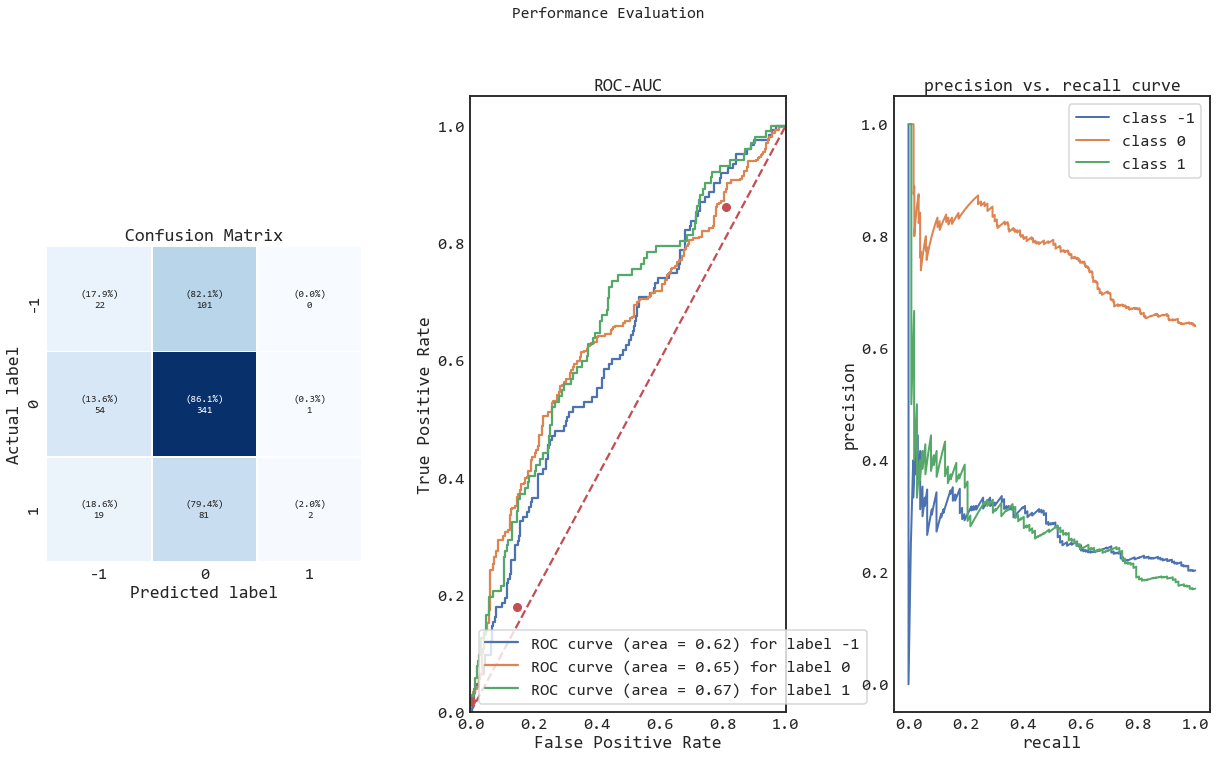

<IPython.core.display.Javascript object>

In [75]:
rf_clf, rf_clf_perf = run_rf_model(X_train, y_train, X_validate, y_validate)
agg_res["rf_dbars_mixed_all_feat"] = format_results(rf_clf_perf)

## Bagging

{'accuracy': array([0.8019, 0.6377, 0.8357]),
 'cohens_kappa': 0.0,
 'f1_score': array([0.    , 0.7788, 0.    ]),
 'mcc': 0.0,
 'precision': array([   nan, 0.6377,    nan]),
 'recall': array([0., 1., 0.]),
 'specificity': array([1., 0., 1.])}


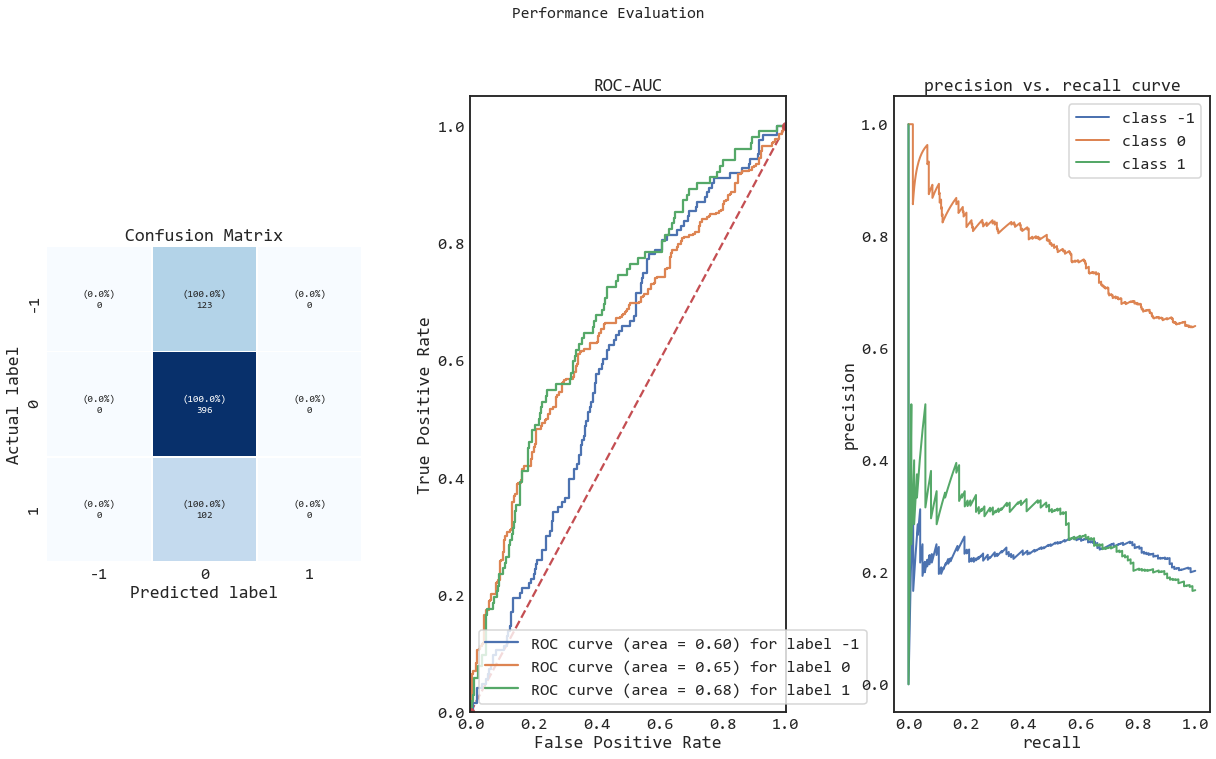

<IPython.core.display.Javascript object>

In [76]:
bag_clf, bag_clf_perf = run_bag_model(X_train, y_train, X_validate, y_validate)
agg_res["bag_dbars_mixed_all_feat"] = format_results(bag_clf_perf)

## Lightgbm model

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
{'accuracy': array([0.7246, 0.6071, 0.8148]),
 'cohens_kappa': 0.051,
 'f1_score': array([0.1972, 0.7277, 0.1353]),
 'mcc': 0.0551,
 'precision': array([0.2333, 0.652 , 0.2903]),
 'recall': array([0.1707, 0.8232, 0.0882]),
 'specificity': array([0.8614, 0.2267, 0.9576])}


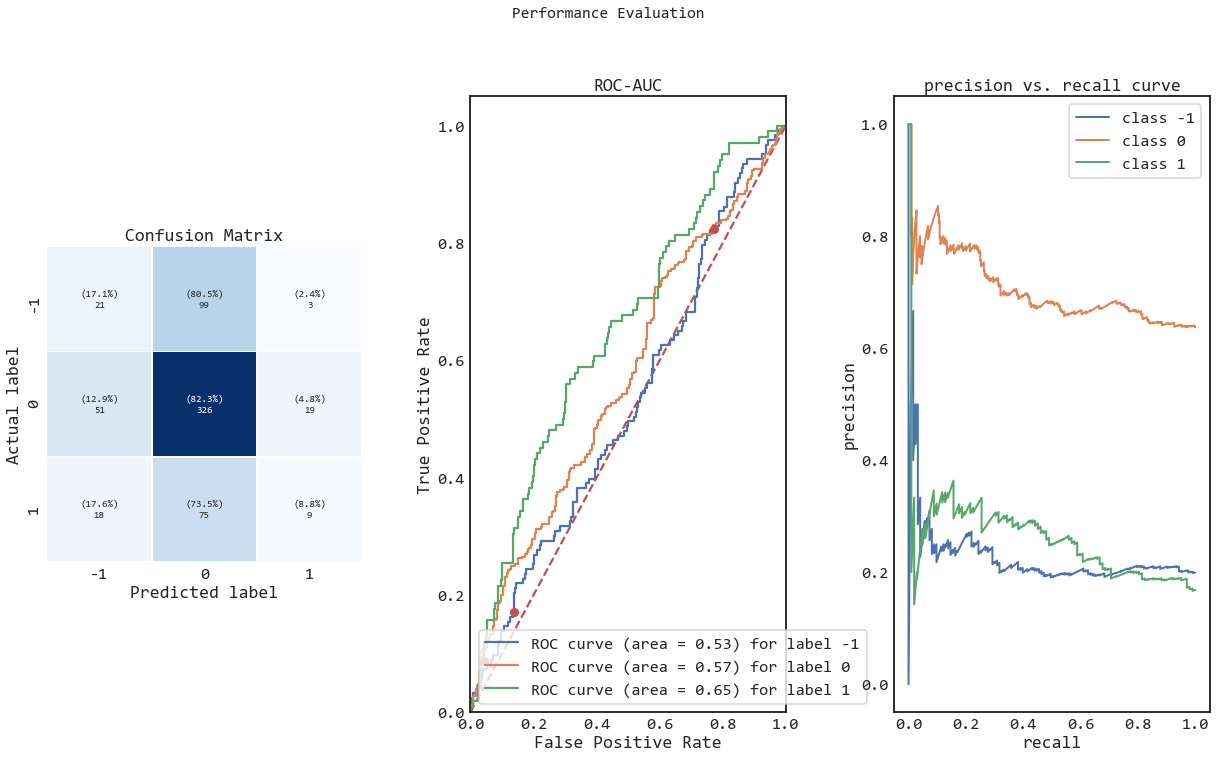

<IPython.core.display.Javascript object>

In [77]:
gbm_clf, gbm_perf = run_gbm_model(X_train, y_train, X_validate, y_validate)
agg_res["gbm_dbars_mixed_all_feat"] = format_results(gbm_perf)

## Feature Selection

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
              mean
feature           
tick_num  0.179321
open      0.136563
high      0.039965
low       0.075485
close     0.048419
-------------------------
TAIL num rows: 5
                                      mean
feature                                   
rank_rvol_average_price_480_48    0.167222
rank_rsi_close_480_48             0.251049
rank_rsi_average_price_480_48     0.061451
rank_racorr_close_480_48          0.381995
rank_racorr_average_price_480_48  0.303956
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 116 entries, tick_num to rank_racorr_average_price_480_48
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mean    116 non-null    float64
dtypes: float64(1)
memory u

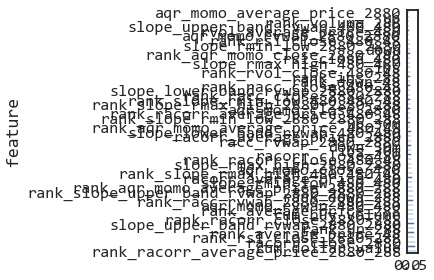

<IPython.core.display.Javascript object>

In [78]:
imp = shap_imp(gbm_clf, X_train)
cprint(imp)

top_shap_feat_mix = (
    imp[(imp["mean"] > imp["mean"].mean())].squeeze().sort_values(ascending=False)
)
top_shap_feat_mix.plot.barh()
plt.tight_layout()

pprint(top_shap_feat_mix.index.tolist())

## Get Feature Matrix and targets for train validate test splits

In [79]:
feature_cols = top_shap_feat_mix.index

y_col = "bin"
X_train, y_train = get_Xy(df_train, labels, feature_cols, y_col)
cprint(X_train)
cprint(y_train)

X_validate, y_validate = get_Xy(df_validate, labels, feature_cols, y_col)
cprint(X_validate)
cprint(y_validate)

X_test, y_test = get_Xy(df_test, labels, feature_cols, y_col)
cprint(X_test)
cprint(y_test)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
                     rank_racorr_average_price_2880_288  cum_dollar_value  \
date_time                                                                   
2004-10-25 09:00:00                            0.045296      1.007931e+06   
2004-10-26 09:20:00                            0.379791      1.006138e+06   
2004-10-27 09:30:00                            0.000000      1.005808e+06   
2004-10-28 09:30:00                            0.233449      1.004801e+06   
2004-11-01 09:25:00                            0.351916      1.002281e+06   

                     racorr_close_2880  rank_rsi_close_2880_288  \
date_time                                                         
2004-10-25 09:00:00          -0.049344                 0.550523   
2004-10-26 09:20:00          -0.044427                 0.000

<IPython.core.display.Javascript object>

### RandomForest 

{'accuracy': array([0.7697, 0.628 , 0.7939]),
 'cohens_kappa': 0.1093,
 'f1_score': array([0.2011, 0.7413, 0.2471]),
 'mcc': 0.1173,
 'precision': array([0.3214, 0.666 , 0.3088]),
 'recall': array([0.1463, 0.8359, 0.2059]),
 'specificity': array([0.9237, 0.2622, 0.9094])}


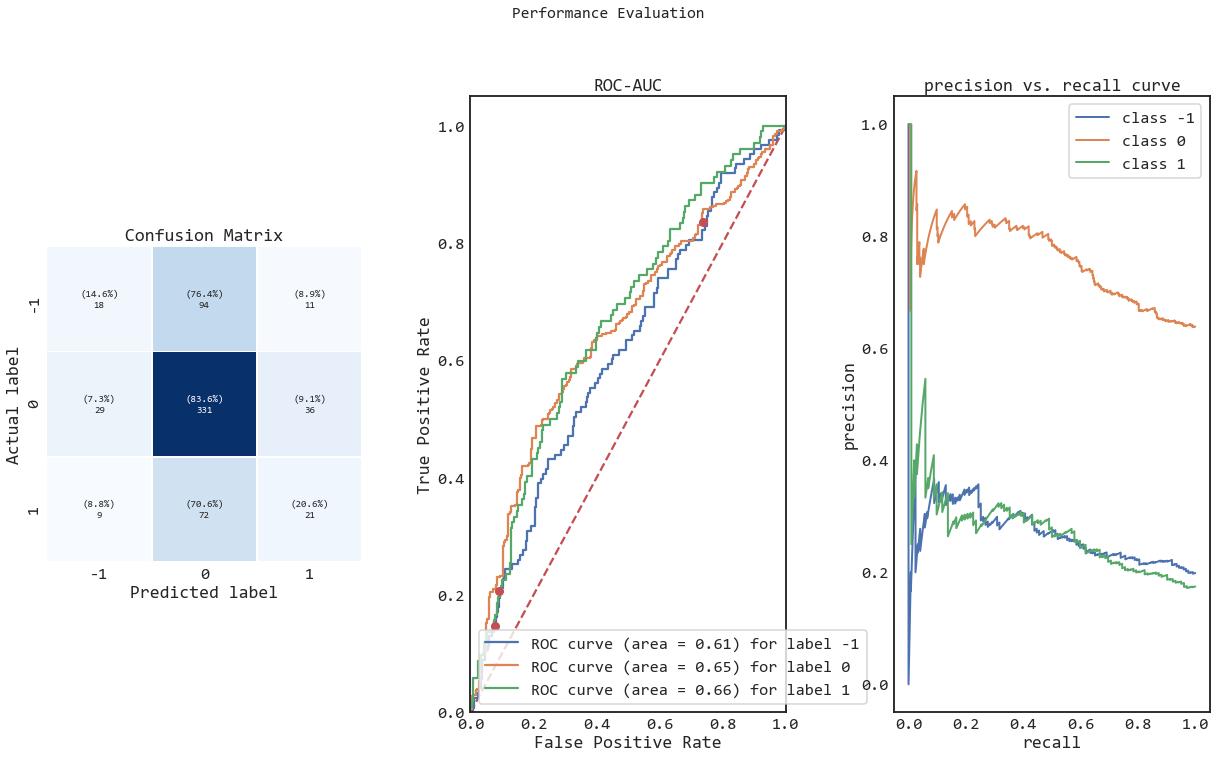

<IPython.core.display.Javascript object>

In [80]:
rf_clf, rf_clf_perf = run_rf_model(X_train, y_train, X_validate, y_validate)
agg_res["rf_dbars_mixed_shap_feat"] = format_results(rf_clf_perf)

#### View Raw Backtest Performance Estimate

start                    2013-01-02 07:50:00
end                      2015-12-31 11:30:00
rf                                  0.000000
total_return                        0.404309
cagr                                0.120155
max_drawdown                       -0.070385
calmar                              1.707097
mtd                                 0.095908
three_month                         0.129987
six_month                           0.240660
ytd                                 0.300362
one_year                            0.300362
three_year                          0.120155
five_year                                NaN
ten_year                                 NaN
incep                               0.120155
daily_sharpe                        1.563983
daily_sortino                       4.162939
daily_mean                          0.196973
daily_vol                           0.125943
daily_skew                          8.062480
daily_kurt                        112.565034
best_day  

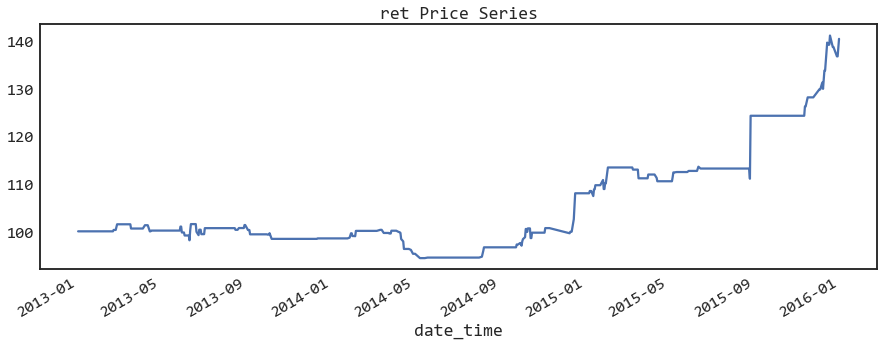

<IPython.core.display.Javascript object>

In [81]:
get_raw_performance_estimate(rf_clf, X_validate, labels["ret"])

### LightGBM

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
{'accuracy': array([0.7568, 0.6135, 0.818 ]),
 'cohens_kappa': 0.046,
 'f1_score': array([0.1749, 0.7419, 0.124 ]),
 'mcc': 0.054,
 'precision': array([0.2667, 0.6461, 0.2963]),
 'recall': array([0.1301, 0.8712, 0.0784]),
 'specificity': array([0.9116, 0.16  , 0.9634])}


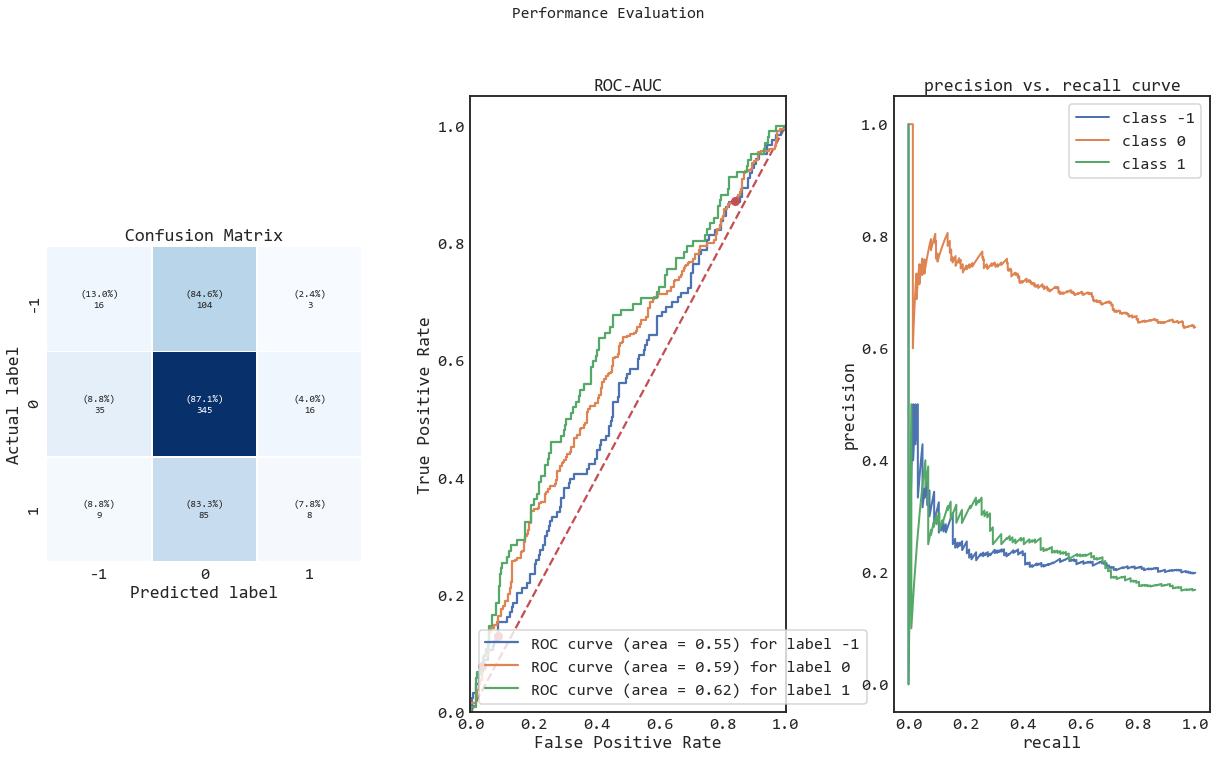

<IPython.core.display.Javascript object>

In [82]:
gbm, gbm_perf = run_gbm_model(X_train, y_train, X_validate, y_validate)
agg_res["gbm_dbars_mixed_shap_feat"] = format_results(gbm_perf)

#### View Raw Backtest Performance Estimate

start                    2013-01-02 07:50:00
end                      2015-12-31 11:30:00
rf                                  0.000000
total_return                        0.200677
cagr                                0.063021
max_drawdown                       -0.064521
calmar                              0.976763
mtd                                 0.000000
three_month                        -0.006537
six_month                           0.165676
ytd                                 0.154618
one_year                            0.154618
three_year                          0.063021
five_year                                NaN
ten_year                                 NaN
incep                               0.063021
daily_sharpe                        0.768702
daily_sortino                       2.370388
daily_mean                          0.111655
daily_vol                           0.145252
daily_skew                         15.038192
daily_kurt                        289.145014
best_day  

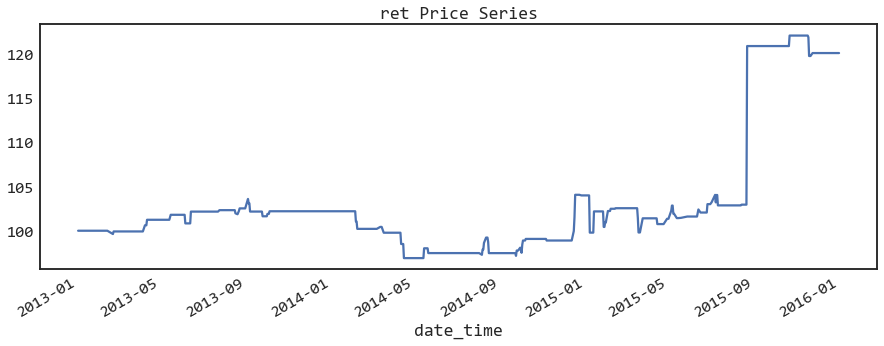

<IPython.core.display.Javascript object>

In [83]:
get_raw_performance_estimate(gbm, X_validate, labels["ret"])

Both models improved their ability to distinguish classes. Random Forest outperformed slightly with a better Matthews Correlation Coefficient but not by much. I'm going to to optimize using RandomForest but LightGBM may be good additional homework.

## Optimize with Neptune and Optuna, Use best parameters on hold out set

Please see the **run_es_feature_hyperoptuna_randomforest_mlfinlab_mixed_timeframes.py** script that implements this portion. For some reason it blows up the Juypter Notebook memory usage and crashes the Kernel.

## fit best params

{'accuracy': array([0.6779, 0.5797, 0.6924]),
 'cohens_kappa': 0.1913,
 'f1_score': array([0.3671, 0.5837, 0.3612]),
 'mcc': 0.2098,
 'precision': array([0.3005, 0.7922, 0.2741]),
 'recall': array([0.4715, 0.4621, 0.5294]),
 'specificity': array([0.7289, 0.7867, 0.7245])}


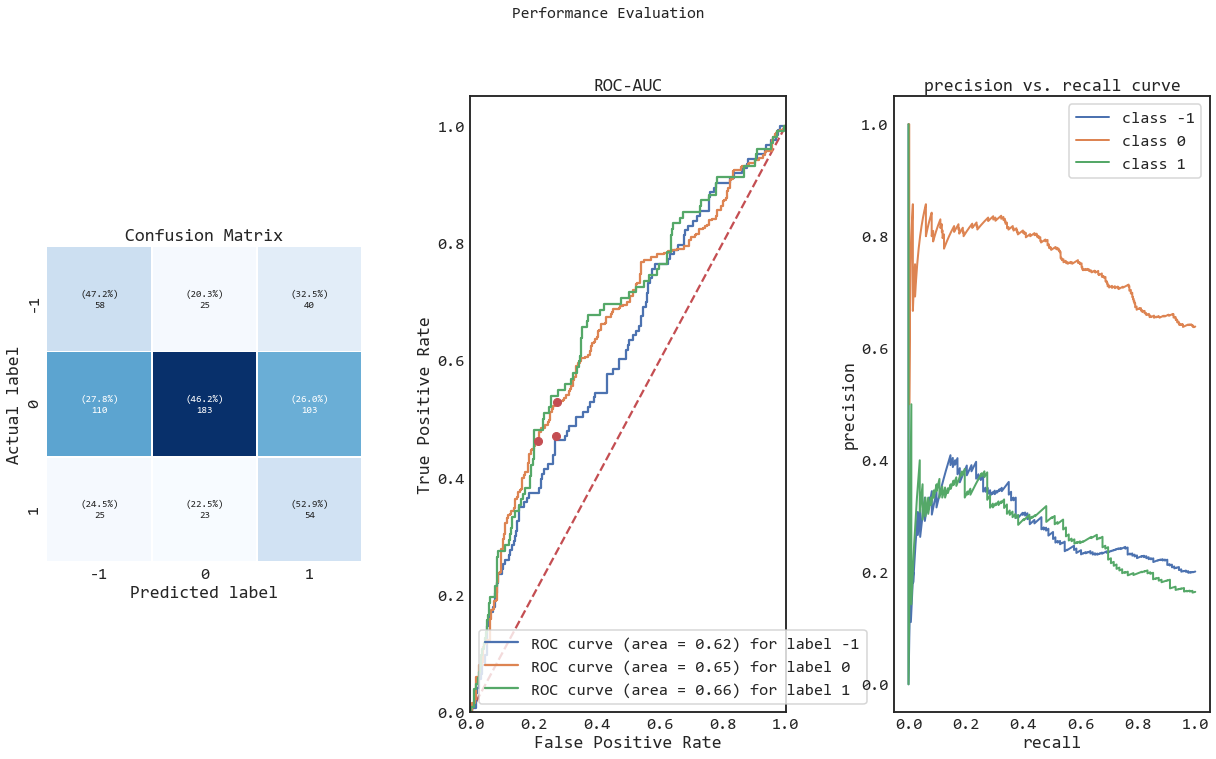

<IPython.core.display.Javascript object>

In [84]:
best_params = {
    "n_estimators": 1500,
    "max_depth": 7,
    "min_samples_split": 0.10,
    "max_features": 0.26,
}

rf_val_clf, rf_val_clf_perf = run_rf_model(
    X_train, y_train, X_validate, y_validate, params=best_params
)
agg_res["rf_dbars_mixed_shap_optuna"] = format_results(rf_val_clf_perf)

### View Raw Backtest Performance Estimate

start                    2013-01-02 07:50:00
end                      2015-12-31 11:30:00
rf                                  0.000000
total_return                        0.705014
cagr                                0.195190
max_drawdown                       -0.156469
calmar                              1.247472
mtd                                 0.199394
three_month                         0.207048
six_month                           0.131271
ytd                                 0.237751
one_year                            0.237751
three_year                          0.195190
five_year                                NaN
ten_year                                 NaN
incep                               0.195190
daily_sharpe                        1.493079
daily_sortino                       2.368344
daily_mean                          0.320974
daily_vol                           0.214974
daily_skew                         -0.880232
daily_kurt                         47.315879
best_day  

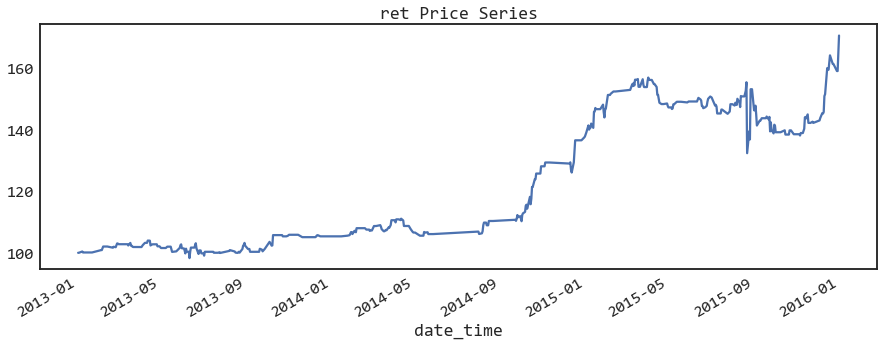

<IPython.core.display.Javascript object>

In [85]:
get_raw_performance_estimate(rf_val_clf, X_validate, labels["ret"])

## final test

{'accuracy': array([0.6815, 0.5505, 0.6461]),
 'cohens_kappa': 0.1783,
 'f1_score': array([0.4362, 0.5022, 0.335 ]),
 'mcc': 0.2008,
 'precision': array([0.3775, 0.7588, 0.2378]),
 'recall': array([0.5165, 0.3753, 0.5667]),
 'specificity': array([0.7332, 0.8179, 0.661 ])}


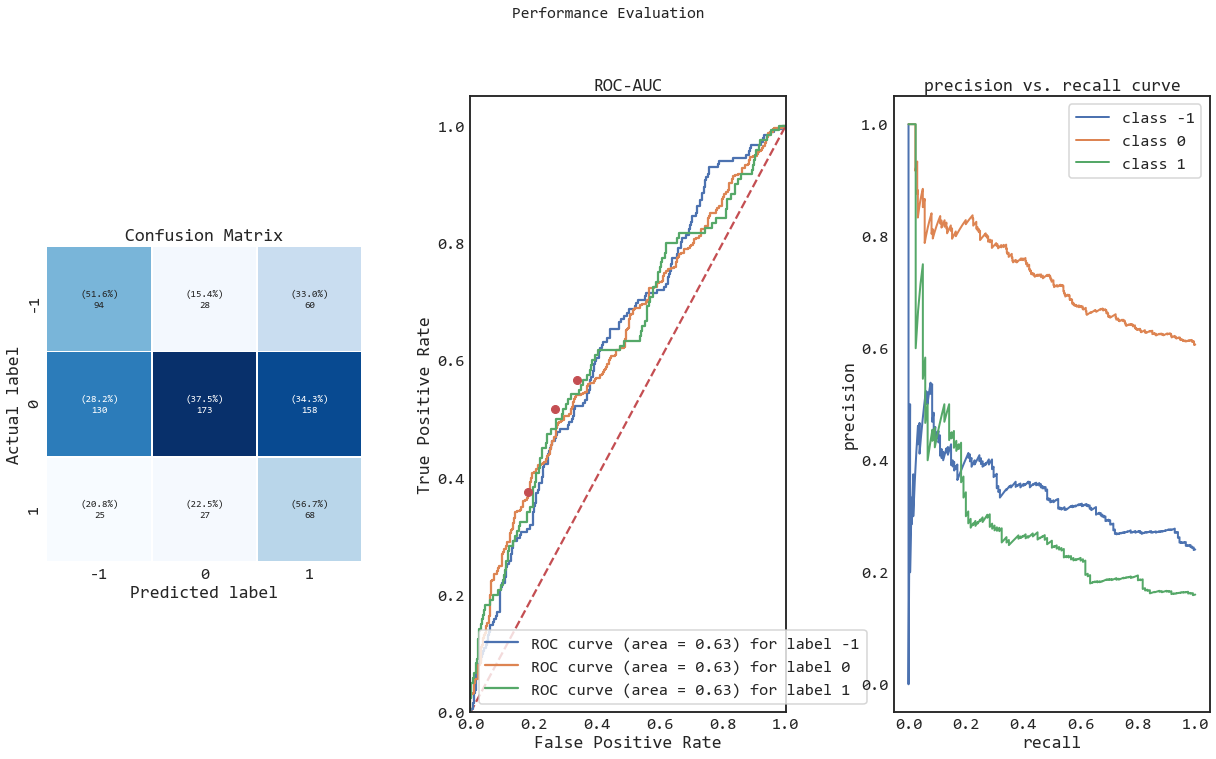

<IPython.core.display.Javascript object>

In [86]:
rf_test_clf, rf_test_clf_perf = run_rf_model(
    X_train, y_train, X_test, y_test, params=best_params
)

agg_res["rf_dbars_mixed_shap_optuna_oos"] = format_results(rf_test_clf_perf)

#### View Raw Backtest Performance Estimate

start                    2016-01-04 07:00:00
end                      2019-05-13 12:35:00
rf                                  0.000000
total_return                        3.232200
cagr                                0.537514
max_drawdown                       -0.090663
calmar                              5.928693
mtd                                 0.066066
three_month                         0.153173
six_month                           0.730823
ytd                                 0.282888
one_year                            1.444876
three_year                          0.499846
five_year                           0.537514
ten_year                            0.537514
incep                               0.537514
daily_sharpe                        3.915005
daily_sortino                       9.205270
daily_mean                          0.953450
daily_vol                           0.243537
daily_skew                          1.688169
daily_kurt                          9.203863
best_day  

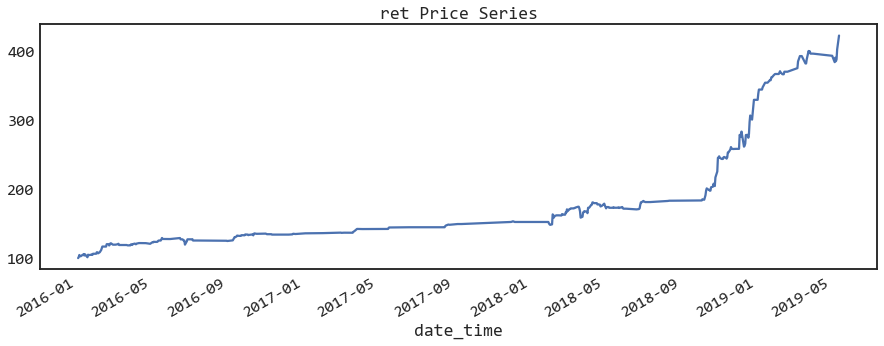

<IPython.core.display.Javascript object>

In [87]:
get_raw_performance_estimate(rf_test_clf, X_test, labels["ret"])

# Analysis and Summary Conclusions

The feature set we created has predictive power in these experiments. Using RandomForest ensemble classifiers we were able to show that the models were able to generalize relatively well to the holdout set, which was 100% oos in the experiment. 

The model showed maximum predictive and maximum estimated backtest performance when we combined feature sets from multiple time frames. In this case that was the 5 minute and 30 minute feature sets. 

While the binary outcome performance was reasonable also, the mlfinlab approach is recommended due to effective data reduction and computational efficiency with large datasets.

Overall the approach demonstrated shows that this model may have economic value if utilized in a decision making capacity for a trading algorithm.

In [89]:
summary = pd.DataFrame.from_dict(agg_res).T.sort_values("mcc", ascending=False)
summary

accuracy  precision  recall     mcc  \
rf_dbars_mixed_shap_optuna        0.6500     0.4556  0.4877  0.2098   
rf_dbars_mixed_shap_optuna_oos    0.6260     0.4580  0.4862  0.2008   
rf_multiclass_all_feat            0.7038     0.4075  0.4162  0.1816   
rf_dbars_shap_optuna              0.6275     0.4418  0.4622  0.1803   
rf_dbars_shap_feat                0.7112     0.4315  0.4214  0.1376   
rf_multiclass_shap_feat           0.6012     0.4139  0.4366  0.1335   
rf_dbars_shap_optuna_oos          0.5692     0.3784  0.3865  0.1207   
rf_dbars_mixed_shap_feat          0.7305     0.4321  0.3960  0.1173   
gbm_dbars_shap_feat               0.7391     0.4370  0.3699  0.0890   
rf_dbars_all_feat                 0.7305        NaN  0.3619  0.0797   
bag_multiclass_all_feat           0.6600        NaN  0.3471  0.0684   
gbm_dbars_all_feat                0.7059     0.3907  0.3668  0.0661   
rf_multiclass_shap_optuna         0.4357     0.4096  0.3889  0.0632   
gbm_dbars_mixed_all_feat          0.7155     0.3919  0.3607  0.0551   
gbm_dbars_mixed_shap_feat         0.7294     0.4030  0.3599  0.0540   
rf_dbars_mixed_all_feat           0.7252     0.5168  0.3532  0.0523   
gbm_dbars_shap_optuna_oos         0.7274     0.4328  0.3443  0.0393   
rf_multiclass_shap_optuna_oos     0.3862     0.4030  0.3630  0.0386   
gbm_multiclass_all_feat           0.6480     0.3682  0.3372  0.0365   
gbm_dbars_shap_optuna             0.7381     0.4047  0.3422  0.0246   
bag_dbars_shap_feat               0.7584        NaN  0.3333  0.0000   
bag_dbars_all_feat                0.7584        NaN  0.3333  0.0000   
bag_dbars_mixed_all_feat          0.7584        NaN  0.3333  0.0000   

                                specificity  f1_score  cohens_kappa  
rf_dbars_mixed_shap_optuna           0.7467    0.4373        0.1913  
rf_dbars_mixed_shap_optuna_oos       0.7374    0.4245        0.1783  
rf_multiclass_all_feat               0.7307    0.4027        0.1807  
rf_dbars_shap_optuna                 0.7372    0.4104        0.1603  
rf_dbars_shap_feat                   0.7103    0.4247        0.1367  
rf_multiclass_shap_feat              0.7170    0.3384        0.1158  
rf_dbars_shap_optuna_oos             0.7112    0.2719        0.0845  
rf_dbars_mixed_shap_feat             0.6984    0.3965        0.1093  
gbm_dbars_shap_feat                  0.6883    0.3582        0.0750  
rf_dbars_all_feat                    0.6891    0.3299        0.0698  
bag_multiclass_all_feat              0.6799    0.2732        0.0380  
gbm_dbars_all_feat                   0.6874    0.3626        0.0636  
rf_multiclass_shap_optuna            0.6842    0.1654        0.0319  
gbm_dbars_mixed_all_feat             0.6819    0.3534        0.0510  
gbm_dbars_mixed_shap_feat            0.6783    0.3469        0.0460  
rf_dbars_mixed_all_feat              0.6809    0.3273        0.0454  
gbm_dbars_shap_optuna_oos            0.6734    0.2959        0.0236  
rf_multiclass_shap_optuna_oos        0.6742    0.0895        0.0131  
gbm_multiclass_all_feat              0.6704    0.2303        0.0107  
gbm_dbars_shap_optuna                0.6710    0.3043        0.0177  
bag_dbars_shap_feat                  0.6667    0.2596        0.0000  
bag_dbars_all_feat                   0.6667    0.2596        0.0000  
bag_dbars_mixed_all_feat             0.6667    0.2596        0.0000

<IPython.core.display.Javascript object>

In [90]:
summary_oos = summary.loc[[x for x in summary.index if "oos" in x]]
summary_oos

accuracy  precision  recall     mcc  \
rf_dbars_mixed_shap_optuna_oos    0.6260     0.4580  0.4862  0.2008   
rf_dbars_shap_optuna_oos          0.5692     0.3784  0.3865  0.1207   
gbm_dbars_shap_optuna_oos         0.7274     0.4328  0.3443  0.0393   
rf_multiclass_shap_optuna_oos     0.3862     0.4030  0.3630  0.0386   

                                specificity  f1_score  cohens_kappa  
rf_dbars_mixed_shap_optuna_oos       0.7374    0.4245        0.1783  
rf_dbars_shap_optuna_oos             0.7112    0.2719        0.0845  
gbm_dbars_shap_optuna_oos            0.6734    0.2959        0.0236  
rf_multiclass_shap_optuna_oos        0.6742    0.0895        0.0131

<IPython.core.display.Javascript object>

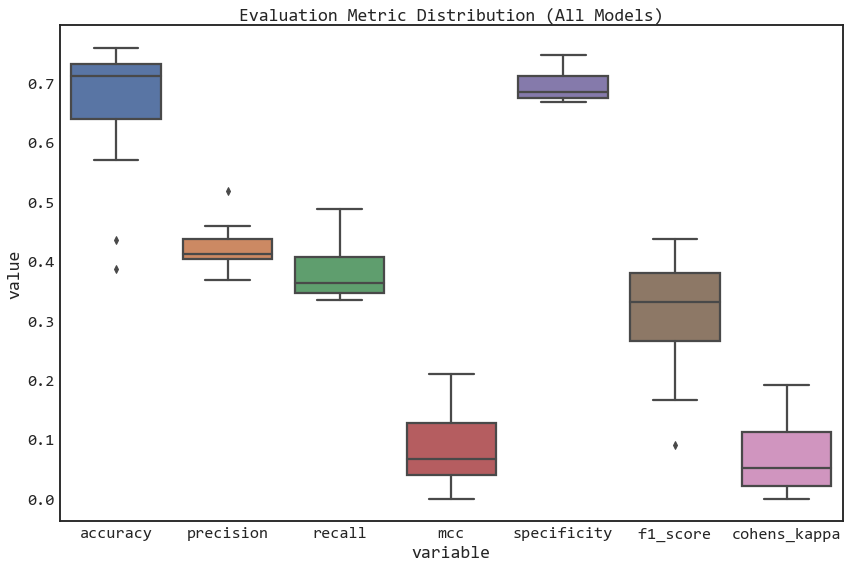

<IPython.core.display.Javascript object>

In [91]:
melt = pd.melt(summary)
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x="variable", y="value", data=melt, ax=ax)
ax.set_title("Evaluation Metric Distribution (All Models)")
plt.tight_layout()